<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Specitication-of-Experiment-Settings" data-toc-modified-id="Specitication-of-Experiment-Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Specitication of Experiment Settings</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Utility-functions" data-toc-modified-id="Utility-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Utility functions</a></span></li><li><span><a href="#Loss/Error-functions" data-toc-modified-id="Loss/Error-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loss/Error functions</a></span><ul class="toc-item"><li><span><a href="#Generate-List-of-Monomial-Identifiers" data-toc-modified-id="Generate-List-of-Monomial-Identifiers-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Generate List of Monomial Identifiers</a></span></li></ul></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Data-Inspection" data-toc-modified-id="Data-Inspection-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Inspection</a></span></li><li><span><a href="#Lambda-Network-Training-+-Weigh/Bias-saving" data-toc-modified-id="Lambda-Network-Training-+-Weigh/Bias-saving-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Lambda Network Training + Weigh/Bias saving</a></span></li><li><span><a href="#Save-Lambda-Model-scores" data-toc-modified-id="Save-Lambda-Model-scores-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save Lambda-Model scores</a></span></li><li><span><a href="#Mail-Notification" data-toc-modified-id="Mail-Notification-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Mail Notification</a></span></li></ul></div>

# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [ ]:
%load_ext email_notify_magic

In [1]:
import math
def nCr(n,r):
    f = math.factorial
    return f(n) // f(r) // f(n-r)

In [2]:
d = 3
n = 4
sparsity = nCr(n+d, d)


x_max = 1#10 #this number excluded
x_min = -1#-10
x_step = 0.01#0.1
a_max = 10 #this number excluded
a_min = -10
a_step = 0.1

lambda_dataset_size = 1000 #specify the number of data points to train the lambda net on for loading (must be same as in previous notebook)

number_formulas_load = 500 #manually specify number of formulas for loading file (must be the same as used in the previous notebook)
number_of_lambda_nets = number_formulas_load #use this parameter to select how many lambda nets should be generated (must be smaller or equal to number_formulas_load)


#lambda net specifications 
batch_size = 64
epochs = 200
lambda_network_layers = [5*sparsity]
dropout = 0.0
optimizer='SGD'

each_epochs_save = 5  #specifies the number of epochs to checkpoint lambda network weights, if None no checkpointing


n_jobs = -3


In [3]:
##############DO NOT CHANGE###################
variables = 'abcdefghijklmnopqrstuvwxyz'[:n]

same_training_all_polynomials = True

RANDOM_SEED = 42

seed_method = True
shuffle = True

layers_str = ''.join([str(neurons) + '-' for neurons in lambda_network_layers])

advanced_metric_dataset_size = 10#200

if same_training_all_polynomials:
    training_string = '_same'
else:
    training_string = '_diverse'

generate_subset = True if number_of_lambda_nets < number_formulas_load else False

    
if generate_subset:
    data_size = number_of_lambda_nets
else:
    data_size = number_formulas_load

if seed_method and shuffle:
    seed_shuffle_string = '_shuffleSeedMethod'
elif not seed_method and shuffle:
    seed_shuffle_string = '_shuffleNoSeedMethod'
elif seed_method and not shuffle:
    seed_shuffle_string = '_noShuffleSeedMethod'
elif not seed_method and not shuffle:
    seed_shuffle_string = '_noShuffleNoSeedMethod'
    
use_gpu = False
if use_gpu:
    gpu_numbers = '0'
else:
    gpu_numbers = ''
    
structure = '_' + layers_str + str(epochs) + 'e' + str(batch_size) + 'b_' + optimizer 
    
filename = seed_shuffle_string + '_' + str(RANDOM_SEED) + structure

## Imports

In [4]:
import ttg
from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema


import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers
import shutil

import logging
logging.getLogger('tensorflow').disabled = True

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns
sns.set_style("darkgrid")
np.set_printoptions(suppress=True)

import tensorflow as tf
import random 
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
#keras.backend.set_epsilon(10e-3)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


## Utility functions

In [6]:
def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

def chunks(lst, chunksize):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), chunksize):
        yield lst[i:i + chunksize]

#test for exact equality
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if np.array_equal(elem, myarr)), False)

def prod(iterable):
    return reduce(operator.mul, iterable, 1)


ALPHABET = \
  "0123456789abcdefghijklmnopqrstuvwxyz"

def encode (n):
    try:
        return ALPHABET [n]
    except IndexError:
        raise Exception ("cannot encode: %s" % n)
        
def dec_to_base (dec = 0, base = 16):
    if dec < base:
        return encode (dec)
    else:
        return dec_to_base (dec // base, base) + encode (dec % base)

In [56]:
list(pairwise([1,2,3]))

[(1, 2)]

## Loss/Error functions

In [7]:
def calcualate_function_with_data(coefficient_list, variable_values):
    
    global list_of_monomial_identifiers
    
    result = 0    
    for coefficient_value, coefficient_multipliers in zip(coefficient_list, list_of_monomial_identifiers):
        partial_results = [variable_value**int(coefficient_multiplier) for coefficient_multiplier, variable_value in zip(coefficient_multipliers, variable_values)]
        
        result += coefficient_value * reduce(lambda x, y: x*y, partial_results)

    return result, variable_values
 
def calculate_function_values_from_polynomial(true_value_test, evaluation_dataset):

    if isinstance(true_value_test, pd.DataFrame):
        true_value_test = true_value_test.values
        
    true_value_fv = []
    true_value_coeff = []
        
    for evaluation in evaluation_dataset:
        true_function_value, true_coeff = calcualate_function_with_data(true_value_test, evaluation)
       
        true_value_fv.append(true_function_value) 
        true_value_coeff.append(true_coeff)
        
    return np.array(true_value_coeff), np.array(true_value_fv)


In [8]:
def root_mean_squared_error(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
            
            
    return tf.math.sqrt(K.mean(K.square(y_pred - y_true))) 

def accuracy_multilabel(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    if 'float' in str(y_true[0].dtype):        
        if tf.is_tensor(y_true):
            y_true = tf.dtypes.cast(y_true, tf.float32) 
        else:
            y_true = y_true.astype('float32')
        if tf.is_tensor(y_pred):
            y_pred = tf.dtypes.cast(y_pred, tf.float32)
        else:
            y_pred = y_pred.astype('float32')
            
        n_digits = int(-np.log10(a_step))
        
        y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
        y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(tf.reduce_all(K.equal(y_true, y_pred), axis=1), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def accuracy_single(y_true, y_pred):
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    if 'float' in str(y_true[0].dtype):        
        if tf.is_tensor(y_true):
            y_true = tf.dtypes.cast(y_true, tf.float32) 
        else:
            y_true = y_true.astype('float32')
        if tf.is_tensor(y_pred):
            y_pred = tf.dtypes.cast(y_pred, tf.float32)
        else:
            y_pred = y_pred.astype('float32')
            
        n_digits = int(-np.log10(a_step))
        
        y_true = tf.math.round(y_true * 10**n_digits) / (10**n_digits) 
        y_pred = tf.math.round(y_pred * 10**n_digits) / (10**n_digits) 
        
    return K.mean(tf.dtypes.cast(tf.dtypes.cast(K.equal(y_true, y_pred), tf.int32), tf.float32))#tf.reduce_all(K.equal(K.equal(y_true, y_pred), True), axis=1)#K.all(K.equal(y_true, y_pred)) #K.equal(y_true, y_pred)                        

def mean_absolute_percentage_error_keras(y_true, y_pred, epsilon=10e-3): 
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values    
        
    if tf.is_tensor(y_true):
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    else:
        y_true = tf.convert_to_tensor(y_true)
        y_true = tf.dtypes.cast(y_true, tf.float32) 
    if tf.is_tensor(y_pred):
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
    else:
        y_pred = tf.convert_to_tensor(y_pred)
        y_pred = tf.dtypes.cast(y_pred, tf.float32)
        
    epsilon = tf.convert_to_tensor(epsilon)
    epsilon = tf.dtypes.cast(epsilon, tf.float32)
        
    return tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred, y_true),(y_true + epsilon))))

def huber_loss_delta_set(y_true, y_pred):
    return keras.losses.huber_loss(y_true, y_pred, delta=0.3)

def relative_absolute_average_error(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
       
    #error value calculation    
    result = np.sum(np.abs(y_true-y_pred))/(y_true.shape[0]*np.std(y_true)) #correct STD?
    
    return result


def relative_maximum_average_error(y_true, y_pred):
    
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    #error value calculation    
    result = np.max(y_true-y_pred)/np.std(y_true) #correct STD?
    
    return result

### Generate List of Monomial Identifiers

In [9]:
list_of_monomial_identifiers_extended = []
for i in tqdm(range((d+1)**n)):    
    monomial_identifier = dec_to_base(i, base = (d+1)).zfill(n) 
    list_of_monomial_identifiers_extended.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers_extended)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers_extended)

list_of_monomial_identifiers = []
for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):
    monomial_identifier_values = list(map(int, list(monomial_identifier)))
    if sum(monomial_identifier_values) <= d:
        list_of_monomial_identifiers.append(monomial_identifier)

print('List length: ' + str(len(list_of_monomial_identifiers)))
print('Number of monomials in a polynomial with ' + str(n) + ' variables and degree ' + str(d) + ': ' + str(nCr(n+d, d)))
print('Sparsity: ' + str(sparsity))
print(list_of_monomial_identifiers)

<ipython-input-9-661ec6648fcc>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range((d+1)**n)):



List length: 256
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0013', '0020', '0021', '0022', '0023', '0030', '0031', '0032', '0033', '0100', '0101', '0102', '0103', '0110', '0111', '0112', '0113', '0120', '0121', '0122', '0123', '0130', '0131', '0132', '0133', '0200', '0201', '0202', '0203', '0210', '0211', '0212', '0213', '0220', '0221', '0222', '0223', '0230', '0231', '0232', '0233', '0300', '0301', '0302', '0303', '0310', '0311', '0312', '0313', '0320', '0321', '0322', '0323', '0330', '0331', '0332', '0333', '1000', '1001', '1002', '1003', '1010', '1011', '1012', '1013', '1020', '1021', '1022', '1023', '1030', '1031', '1032', '1033', '1100', '1101', '1102', '1103', '1110', '1111', '1112', '1113', '1120', '1121', '1122', '1123', '1130', '1131', '1132', '1133', '1200', '1201', '1202', '1203', '1210', '1211', '1212', '1213', '1220', '1221', '1222', '1223', '1230', '1231', '1232', '1233', '1

<ipython-input-9-661ec6648fcc>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for monomial_identifier in tqdm(list_of_monomial_identifiers_extended):



List length: 35
Number of monomials in a polynomial with 4 variables and degree 3: 35
Sparsity: 35
['0000', '0001', '0002', '0003', '0010', '0011', '0012', '0020', '0021', '0030', '0100', '0101', '0102', '0110', '0111', '0120', '0200', '0201', '0210', '0300', '1000', '1001', '1002', '1010', '1011', '1020', '1100', '1101', '1110', '1200', '2000', '2001', '2010', '2100', '3000']


## Load Data

In [10]:
path_polynomials = './data/saved_polynomial_lists/polynomials_sample' + str(number_formulas_load) + '_variables_' + str(n) +  '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step) + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '.csv'
polynomials_list_df = pd.read_csv(path_polynomials)

path_X_data = './data/saved_polynomial_lists/X_sample' + str(number_formulas_load) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) +  training_string + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_polynomial_lists/y_sample' + str(number_formulas_load) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) +  training_string + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
if generate_subset:
    polynomials_list_df = polynomials_list_df.sample(n=number_of_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_lambda_nets)
    random.seed(RANDOM_SEED)


In [11]:
#clear files
if each_epochs_save != None:
    try:
        # Create target Directory
        os.mkdir('./data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:

        for i in range(epochs//each_epochs_save):    
            path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size)  + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str((i+1)*each_epochs_save).zfill(3)  + filename + '.txt'

            with open(path, 'wt') as text_file:
                text_file.truncate()   
    try:
        # Create target Directory
        os.mkdir('./data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:
        pass
else:
    
    try:
        # Create target Directory
        os.mkdir('./data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:

        path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

        with open(path, 'wt') as text_file:
            text_file.truncate()   
    try:
        # Create target Directory
        os.mkdir('./data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename)
    except FileExistsError:
        pass
                

## Data Inspection

In [12]:
X_data_list[0][1].head()

,0,1,2,3
0,-0.340,-0.230,0.570,0.310
1,0.380,-0.380,0.770,-0.880
2,-0.050,0.460,0.210,-0.450
3,0.940,0.110,-0.300,0.910
4,0.760,0.990,-0.530,-0.300


In [13]:
X_data_list[0][1].head()

,0,1,2,3
0,-0.340,-0.230,0.570,0.310
1,0.380,-0.380,0.770,-0.880
2,-0.050,0.460,0.210,-0.450
3,0.940,0.110,-0.300,0.910
4,0.760,0.990,-0.530,-0.300


In [14]:
X_data_list[0][0].head()

0000    6.300
0001   -7.200
0002   -9.400
0003    8.900
0010   -3.000
Name: 0, dtype: float64

In [15]:
X_data_list[1][0].head()

0000   -9.900
0001    9.400
0002   -6.000
0003    7.800
0010    0.800
Name: 1, dtype: float64

## Lambda Network Training + Weigh/Bias saving

# TODO: Add train to pred and save pred_eval_dataset_train containing train data and use for loss function in interpretation network
    

In [16]:
def train_nn(X_data, y_data, polynomial, callbacks=None, return_history=False, each_epochs_save=None, printing=False, return_model=False):
    
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    if int(tf.__version__[0]) >= 2:
        tf.random.set_seed(RANDOM_SEED)
    else:
        tf.set_random_seed(RANDOM_SEED) 
        
    if isinstance(X_data, pd.DataFrame):
        X_data = X_data.values
    if isinstance(y_data, pd.DataFrame):
        y_data = y_data.values
        
    #split train test valid
        
    X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)           
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)           
     
    #create neural network structure       
    model = Sequential()

    model.add(Dense(lambda_network_layers[0], activation='relu', input_dim=X_data.shape[1])) #1024
    
    if dropout > 0:
        model.add(Dropout(dropout))

    for neurons in lambda_network_layers[1:]:
        model.add(Dense(neurons, activation='relu'))
        if dropout > 0:
            model.add(Dropout(dropout))   
            
    model.add(Dense(1))
    
    
    model.compile(optimizer=optimizer,
                  loss='mae', #huber_loss(val_min, val_max), #'mape',#'mean_absolute_error',#root_mean_squared_error,
                  metrics=[mean_absolute_percentage_error_keras, root_mean_squared_error]
                 )
    
    
    weights = []
    polynomial_pred_list = []
    polynomial_lstsq_true_list = []
        
        

     
    if each_epochs_save == None:   
        #training neurl net
        model_history = model.fit(X_train, 
                      y_train, 
                      epochs=epochs, 
                      batch_size=batch_size, 
                      callbacks=callbacks,
                      validation_data=(X_valid, y_valid),
                      verbose=0,
                      workers=0)
        weights.append(model.get_weights())
        
        history = model_history.history
        
        y_pred_train = model.predict(X_train) 
        y_pred_valid = model.predict(X_valid)                
        y_pred_test = model.predict(X_test)

        term_list_all = []
        y = 0
        for constant, term in zip(polynomial.values, list(polynomial.index)):
            term_list = [int(value_mult) for value_mult in term]
            term_list_all.append(term_list)

        #print(trm_list_all)

        #generate separate arrays for each variable combination
        terms_matrix = []
        for unknowns in X_train:
            terms = []
            for term_multipliers in term_list_all:
                term_value = prod([unknown**multiplier for unknown, multiplier in zip(unknowns, term_multipliers)])

                terms.append(term_value)
            terms_matrix.append(np.array(terms))

        terms_matrix = np.array(terms_matrix)

        polynomial_pred, _, _, _ = np.linalg.lstsq(terms_matrix, y_pred_train.ravel(), rcond=-1)#[::-1]
        polynomial_lstsq_true, _, _, _ = np.linalg.lstsq(terms_matrix, y_train.ravel(), rcond=-1)#[::-1] 
        polynomial_pred_list.append(polynomial_pred)
        polynomial_lstsq_true_list.append(polynomial_lstsq_true)
        
        y_test_polynomial = []
        y_test_lstsq = []
        for entry in X_test:
            true_function_value_pred, _ = calcualate_function_with_data(polynomial_pred, entry)
            true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)   
            y_test_polynomial.append(true_function_value_pred)
            y_test_lstsq.append(true_function_value_lstsq)
        y_test_polynomial = np.array(y_test_polynomial).reshape(len(y_test_polynomial), 1)
        y_test_lstsq = np.array(y_test_lstsq).reshape(len(y_test_lstsq), 1)


        y_valid_polynomial = []  
        y_valid_lstsq = []
        for entry in X_valid:
            true_function_value_pred, _ = calcualate_function_with_data(polynomial_pred, entry)
            true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)
            y_valid_polynomial.append(true_function_value_pred)     
            y_valid_lstsq.append(true_function_value_lstsq)     
        y_valid_polynomial = np.array(y_valid_polynomial).reshape(len(y_valid_polynomial), 1)     
        y_valid_lstsq = np.array(y_valid_lstsq).reshape(len(y_valid_lstsq), 1)     
        
        y_train_polynomial = []  
        y_train_lstsq = []
        for entry in X_train:
            true_function_value_pred, _ = calcualate_function_with_data(polynomial_pred, entry)
            true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)
            y_train_polynomial.append(true_function_value_pred)     
            y_train_lstsq.append(true_function_value_lstsq)     
        y_train_polynomial = np.array(y_train_polynomial).reshape(len(y_train_polynomial), 1)     
        y_train_lstsq = np.array(y_train_lstsq).reshape(len(y_train_lstsq), 1)    
        
        
        pred_list = (y_train, y_pred_train, y_train_polynomial, X_train, y_valid, y_pred_valid, y_valid_polynomial, X_valid, y_test, y_pred_test, y_test_polynomial, X_test)

        mae_test_pred = np.round(mean_absolute_error(y_test, y_pred_test), 4)
        mae_test_polynomial = np.round(mean_absolute_error(y_test, y_test_polynomial), 4)
        mae_test_polynomial_pred = np.round(mean_absolute_error(y_test_polynomial, y_pred_test), 4)
        mae_test_lstsq = np.round(mean_absolute_error(y_test, y_test_lstsq), 4)    

        rmse_test_pred = np.round(root_mean_squared_error(y_test, y_pred_test), 4)    
        rmse_test_polynomial = np.round(root_mean_squared_error(y_test, y_test_polynomial), 4)    
        rmse_test_polynomial_pred = np.round(root_mean_squared_error(y_test_polynomial, y_pred_test), 4)    
        rmse_test_lstsq = np.round(root_mean_squared_error(y_test, y_test_lstsq), 4)    
        
        mape_test_pred = np.round(mean_absolute_percentage_error_keras(y_test, y_pred_test), 4)    
        mape_test_polynomial = np.round(mean_absolute_percentage_error_keras(y_test, y_test_polynomial), 4)    
        mape_test_polynomial_pred = np.round(mean_absolute_percentage_error_keras(y_test_polynomial, y_pred_test), 4)    
        mape_test_lstsq = np.round(mean_absolute_percentage_error_keras(y_test, y_test_lstsq), 4)            

        r2_test_pred = np.round(r2_score(y_test, y_pred_test), 4)
        r2_test_polynomial = np.round(r2_score(y_test, y_test_polynomial), 4)
        r2_test_polynomial_pred = np.round(r2_score(y_test_polynomial, y_pred_test), 4)
        r2_test_lstsq = np.round(r2_score(y_test, y_test_lstsq), 4)
        
        raae_test_pred = np.round(relative_absolute_average_error(y_test, y_pred_test), 4)
        raae_test_polynomial = np.round(relative_absolute_average_error(y_test, y_test_polynomial), 4)
        raae_test_polynomial_pred = np.round(relative_absolute_average_error(y_test_polynomial, y_pred_test), 4)
        raae_test_lstsq = np.round(relative_absolute_average_error(y_test, y_test_lstsq), 4)
        
        rmae_test_pred = np.round(relative_maximum_average_error(y_test, y_pred_test), 4)
        rmae_test_polynomial = np.round(relative_maximum_average_error(y_test, y_test_polynomial), 4)
        rmae_test_polynomial_pred = np.round(relative_maximum_average_error(y_test_polynomial, y_pred_test), 4)
        rmae_test_lstsq = np.round(relative_maximum_average_error(y_test, y_test_lstsq), 4)
        
        fd_test_pred = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size]))), 4)
        fd_test_polynomial = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size]))), 4)
        fd_test_polynomial_pred = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size]))), 4)
        fd_test_lstsq = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_lstsq[:advanced_metric_dataset_size]))), 4)
        
        dtw_test_pred, dtw_complete_test_pred = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size])))
        dtw_test_pred = np.round(dtw_test_pred, 4)
        dtw_test_polynomial, dtw_complete_test_polynomial = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size])))
        dtw_test_polynomial = np.round(dtw_test_polynomial, 4)
        dtw_test_polynomial_pred, dtw_complete_test_polynomial_pred = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size])))
        dtw_test_polynomial_pred = np.round(dtw_test_polynomial_pred, 4)    
        dtw_test_lstsq, dtw_complete_test_lstsq = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_lstsq[:advanced_metric_dataset_size])))
        dtw_test_lstsq = np.round(dtw_test_lstsq, 4)        


        mae_valid_pred = np.round(mean_absolute_error(y_valid, y_pred_valid), 4)
        mae_valid_polynomial = np.round(mean_absolute_error(y_valid, y_valid_polynomial), 4)
        mae_valid_polynomial_pred = np.round(mean_absolute_error(y_valid_polynomial, y_pred_valid), 4)
        mae_valid_lstsq = np.round(mean_absolute_error(y_valid, y_valid_lstsq), 4)
        
        rmse_valid_pred = np.round(root_mean_squared_error(y_valid, y_pred_valid), 4)
        rmse_valid_polynomial = np.round(root_mean_squared_error(y_valid, y_valid_polynomial), 4)
        rmse_valid_polynomial_pred = np.round(root_mean_squared_error(y_valid_polynomial, y_pred_valid), 4)
        rmse_valid_lstsq = np.round(root_mean_squared_error(y_valid, y_valid_lstsq), 4)
        
        mape_valid_pred = np.round(mean_absolute_percentage_error_keras(y_valid, y_pred_valid), 4)
        mape_valid_polynomial = np.round(mean_absolute_percentage_error_keras(y_valid, y_valid_polynomial), 4)
        mape_valid_polynomial_pred = np.round(mean_absolute_percentage_error_keras(y_valid_polynomial, y_pred_valid), 4)
        mape_valid_lstsq = np.round(mean_absolute_percentage_error_keras(y_valid, y_valid_lstsq), 4)
        
        r2_valid_pred = np.round(r2_score(y_valid, y_pred_valid), 4)
        r2_valid_polynomial = np.round(r2_score(y_valid, y_valid_polynomial), 4)
        r2_valid_polynomial_pred = np.round(r2_score(y_valid_polynomial, y_pred_valid), 4)
        r2_valid_lstsq = np.round(r2_score(y_valid, y_valid_lstsq), 4)
        
        raae_valid_pred = np.round(relative_absolute_average_error(y_valid, y_pred_valid), 4)
        raae_valid_polynomial = np.round(relative_absolute_average_error(y_valid, y_valid_polynomial), 4)
        raae_valid_polynomial_pred = np.round(relative_absolute_average_error(y_valid_polynomial, y_pred_valid), 4)
        raae_valid_lstsq = np.round(relative_absolute_average_error(y_valid, y_valid_lstsq), 4)
        
        rmae_valid_pred = np.round(relative_maximum_average_error(y_valid, y_pred_valid), 4) 
        rmae_valid_polynomial = np.round(relative_maximum_average_error(y_valid, y_valid_polynomial), 4) 
        rmae_valid_polynomial_pred = np.round(relative_maximum_average_error(y_valid_polynomial, y_pred_valid), 4) 
        rmae_valid_lstsq = np.round(relative_maximum_average_error(y_valid, y_valid_lstsq), 4) 
        
        fd_valid_pred = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size]))), 4)
        fd_valid_polynomial = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size]))), 4)
        fd_valid_polynomial_pred = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size]))), 4)
        fd_valid_lstsq = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_lstsq[:advanced_metric_dataset_size]))), 4)
        
        dtw_valid_pred, dtw_complete_valid_pred = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size])))
        dtw_valid_pred = np.round(dtw_valid_pred, 4)    
        dtw_valid_polynomial, dtw_complete_valid_polynomial = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size])))
        dtw_valid_polynomial = np.round(dtw_valid_polynomial, 4)       
        dtw_valid_polynomial_pred, dtw_complete_valid_polynomial_pred = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size])))
        dtw_valid_polynomial_pred = np.round(dtw_valid_polynomial_pred, 4)   
        dtw_valid_lstsq, dtw_complete_valid_lstsq = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_lstsq[:advanced_metric_dataset_size])))
        dtw_valid_lstsq = np.round(dtw_valid_lstsq, 4)
       
    
    
    
    #CHANGE TRAIN
        mae_train_pred = np.round(mean_absolute_error(y_train, y_pred_train), 4)
        mae_train_polynomial = np.round(mean_absolute_error(y_train, y_train_polynomial), 4)
        mae_train_polynomial_pred = np.round(mean_absolute_error(y_train_polynomial, y_pred_train), 4)
        mae_train_lstsq = np.round(mean_absolute_error(y_train, y_train_lstsq), 4)
        
        rmse_train_pred = np.round(root_mean_squared_error(y_train, y_pred_train), 4)
        rmse_train_polynomial = np.round(root_mean_squared_error(y_train, y_train_polynomial), 4)
        rmse_train_polynomial_pred = np.round(root_mean_squared_error(y_train_polynomial, y_pred_train), 4)
        rmse_train_lstsq = np.round(root_mean_squared_error(y_train, y_train_lstsq), 4)
        
        mape_train_pred = np.round(mean_absolute_percentage_error_keras(y_train, y_pred_train), 4)
        mape_train_polynomial = np.round(mean_absolute_percentage_error_keras(y_train, y_train_polynomial), 4)
        mape_train_polynomial_pred = np.round(mean_absolute_percentage_error_keras(y_train_polynomial, y_pred_train), 4)
        mape_train_lstsq = np.round(mean_absolute_percentage_error_keras(y_train, y_train_lstsq), 4)
        
        r2_train_pred = np.round(r2_score(y_train, y_pred_train), 4)
        r2_train_polynomial = np.round(r2_score(y_train, y_train_polynomial), 4)
        r2_train_polynomial_pred = np.round(r2_score(y_train_polynomial, y_pred_train), 4)
        r2_train_lstsq = np.round(r2_score(y_train, y_train_lstsq), 4)
        
        raae_train_pred = np.round(relative_absolute_average_error(y_train, y_pred_train), 4)
        raae_train_polynomial = np.round(relative_absolute_average_error(y_train, y_train_polynomial), 4)
        raae_train_polynomial_pred = np.round(relative_absolute_average_error(y_train_polynomial, y_pred_train), 4)
        raae_train_lstsq = np.round(relative_absolute_average_error(y_train, y_train_lstsq), 4)
        
        rmae_train_pred = np.round(relative_maximum_average_error(y_train, y_pred_train), 4) 
        rmae_train_polynomial = np.round(relative_maximum_average_error(y_train, y_train_polynomial), 4) 
        rmae_train_polynomial_pred = np.round(relative_maximum_average_error(y_train_polynomial, y_pred_train), 4) 
        rmae_train_lstsq = np.round(relative_maximum_average_error(y_train, y_train_lstsq), 4) 
        
        fd_train_pred = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size]))), 4)
        fd_train_polynomial = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size]))), 4)
        fd_train_polynomial_pred = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size]))), 4)
        fd_train_lstsq = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_lstsq[:advanced_metric_dataset_size]))), 4)
        
        dtw_train_pred, dtw_complete_train_pred = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size])))
        dtw_train_pred = np.round(dtw_train_pred, 4)    
        dtw_train_polynomial, dtw_complete_train_polynomial = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size])))
        dtw_train_polynomial = np.round(dtw_train_polynomial, 4)       
        dtw_train_polynomial_pred, dtw_complete_train_polynomial_pred = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size])))
        dtw_train_polynomial_pred = np.round(dtw_train_polynomial_pred, 4)   
        dtw_train_lstsq, dtw_complete_train_lstsq = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_lstsq[:advanced_metric_dataset_size])))
        dtw_train_lstsq = np.round(dtw_train_lstsq, 4)

        
        std_train_real = np.std(y_train)
        std_valid_real = np.std(y_valid)
        std_test_real = np.std(y_test)

        std_train_pred = np.std(y_pred_train)
        std_valid_pred = np.std(y_pred_valid)
        std_test_pred = np.std(y_pred_test)

        std_train_polynomial = np.std(y_train_polynomial)
        std_valid_polynomial = np.std(y_valid_polynomial)
        std_test_polynomial = np.std(y_test_polynomial)

        std_train_lstsq = np.std(y_train_lstsq)
        std_valid_lstsq = np.std(y_valid_lstsq)
        std_test_lstsq = np.std(y_test_lstsq)
        
        
        mean_train_real = np.mean(y_train)
        mean_valid_real = np.mean(y_valid)
        mean_test_real = np.mean(y_test)

        mean_train_pred = np.mean(y_pred_train)
        mean_valid_pred = np.mean(y_pred_valid)
        mean_test_pred = np.mean(y_pred_test)

        mean_train_polynomial = np.mean(y_train_polynomial)
        mean_valid_polynomial = np.mean(y_valid_polynomial)
        mean_test_polynomial = np.mean(y_test_polynomial)

        mean_train_lstsq = np.mean(y_train_lstsq)
        mean_valid_lstsq = np.mean(y_valid_lstsq)
        mean_test_lstsq = np.mean(y_test_lstsq)

        result_dict_list =  [{
                         'MAE FV TRAIN PRED': mae_valid_pred,
                         'MAE FV TRAIN POLY': mae_valid_polynomial,
                         'MAE FV TRAIN POLY PRED': mae_valid_polynomial_pred,
                         'MAE FV TRAIN LSTSQ': mae_valid_lstsq,
                         'RMSE FV TRAIN PRED': rmse_valid_pred,
                         'RMSE FV TRAIN POLY': rmse_valid_polynomial,
                         'RMSE FV TRAIN POLY PRED': rmse_valid_polynomial_pred,
                         'RMSE FV TRAIN LSTSQ': rmse_valid_lstsq,
                         'MAPE FV TRAIN PRED': mape_valid_pred,
                         'MAPE FV TRAIN POLY': mape_valid_polynomial,
                         'MAPE FV TRAIN POLY PRED': mape_valid_polynomial_pred,
                         'MAPE FV TRAIN LSTSQ': mape_valid_lstsq,
                         'R2 FV TRAIN PRED': r2_valid_pred,
                         'R2 FV TRAIN POLY': r2_valid_polynomial,
                         'R2 FV TRAIN POLY PRED': r2_valid_polynomial_pred,
                         'R2 FV TRAIN LSTSQ': r2_valid_lstsq,
                         'RAAE FV PRED TRAIN': raae_valid_pred,
                         'RAAE FV TRAIN POLY': raae_valid_polynomial,
                         'RAAE FV TRAIN POLY PRED': raae_valid_polynomial_pred,
                         'RAAE FV TRAIN LSTSQ': raae_valid_lstsq,
                         'RMAE FV TRAIN PRED': rmae_valid_pred,
                         'RMAE FV TRAIN POLY': rmae_valid_polynomial,
                         'RMAE FV TRAIN POLY PRED': rmae_valid_polynomial_pred,
                         'RMAE FV TRAIN LSTSQ': rmae_valid_lstsq,
                         'FD FV TRAIN PRED': fd_valid_pred,   
                         'FD FV TRAIN POLY': fd_valid_polynomial,   
                         'FD FV TRAIN POLY PRED': fd_valid_polynomial_pred,   
                         'FD FV TRAIN LSTSQ': fd_valid_lstsq,   
                         'DTW FV TRAIN PRED': dtw_valid_pred, 
                         'DTW FV TRAIN POLY': dtw_valid_polynomial, 
                         'DTW FV TRAIN POLY PRED': dtw_valid_polynomial_pred, 
                         'DTW FV TRAIN LSTSQ': dtw_valid_lstsq, 
        },{
                         'MAE FV VALID PRED': mae_valid_pred,
                         'MAE FV VALID POLY': mae_valid_polynomial,
                         'MAE FV VALID POLY PRED': mae_valid_polynomial_pred,
                         'MAE FV VALID LSTSQ': mae_valid_lstsq,
                         'RMSE FV VALID PRED': rmse_valid_pred,
                         'RMSE FV VALID POLY': rmse_valid_polynomial,
                         'RMSE FV VALID POLY PRED': rmse_valid_polynomial_pred,
                         'RMSE FV VALID LSTSQ': rmse_valid_lstsq,
                         'MAPE FV VALID PRED': mape_valid_pred,
                         'MAPE FV VALID POLY': mape_valid_polynomial,
                         'MAPE FV VALID POLY PRED': mape_valid_polynomial_pred,
                         'MAPE FV VALID LSTSQ': mape_valid_lstsq,
                         'R2 FV VALID PRED': r2_valid_pred,
                         'R2 FV VALID POLY': r2_valid_polynomial,
                         'R2 FV VALID POLY PRED': r2_valid_polynomial_pred,
                         'R2 FV VALID LSTSQ': r2_valid_lstsq,
                         'RAAE FV PRED VALID': raae_valid_pred,
                         'RAAE FV VALID POLY': raae_valid_polynomial,
                         'RAAE FV VALID POLY PRED': raae_valid_polynomial_pred,
                         'RAAE FV VALID LSTSQ': raae_valid_lstsq,
                         'RMAE FV VALID PRED': rmae_valid_pred,
                         'RMAE FV VALID POLY': rmae_valid_polynomial,
                         'RMAE FV VALID POLY PRED': rmae_valid_polynomial_pred,
                         'RMAE FV VALID LSTSQ': rmae_valid_lstsq,
                         'FD FV VALID PRED': fd_valid_pred,   
                         'FD FV VALID POLY': fd_valid_polynomial,   
                         'FD FV VALID POLY PRED': fd_valid_polynomial_pred,   
                         'FD FV VALID LSTSQ': fd_valid_lstsq,   
                         'DTW FV VALID PRED': dtw_valid_pred, 
                         'DTW FV VALID POLY': dtw_valid_polynomial, 
                         'DTW FV VALID POLY PRED': dtw_valid_polynomial_pred, 
                         'DTW FV VALID LSTSQ': dtw_valid_lstsq, 
        },{
                         'MAE FV TEST PRED': mae_test_pred,
                         'MAE FV TEST POLY': mae_test_polynomial,
                         'MAE FV TEST POLY PRED': mae_test_polynomial_pred,
                         'MAE FV TEST LSTSQ': mae_test_lstsq,
                         'RMSE FV TEST PRED': rmse_test_pred,
                         'RMSE FV TEST POLY': rmse_test_polynomial,
                         'RMSE FV TEST POLY PRED': rmse_test_polynomial_pred,
                         'RMSE FV TEST LSTSQ': rmse_test_lstsq,
                         'MAPE FV TEST PRED': mape_test_pred,
                         'MAPE FV TEST POLY': mape_test_polynomial,
                         'MAPE FV TEST POLY PRED': mape_test_polynomial_pred,
                         'MAPE FV TEST LSTSQ': mape_test_lstsq,
                         'R2 FV TEST PRED': r2_test_pred,
                         'R2 FV TEST POLY': r2_test_polynomial,
                         'R2 FV TEST POLY PRED': r2_test_polynomial_pred,
                         'R2 FV TEST LSTSQ': r2_test_lstsq,
                         'RAAE FV TEST PRED': raae_test_pred,
                         'RAAE FV TEST POLY': raae_test_polynomial,
                         'RAAE FV TEST POLY PRED': raae_test_polynomial_pred,
                         'RAAE FV TEST LSTSQ': raae_test_lstsq,
                         'RMAE FV TEST PRED': rmae_test_pred,
                         'RMAE FV TEST POLY': rmae_test_polynomial,
                         'RMAE FV TEST POLY PRED': rmae_test_polynomial_pred,        
                         'RMAE FV TEST LSTSQ': rmae_test_lstsq,
                         'FD FV TEST PRED': fd_test_pred,    
                         'FD FV TEST POLY': fd_test_polynomial,    
                         'FD FV TEST POLY PRED': fd_test_polynomial_pred, 
                         'FD FV TEST LSTSQ': fd_test_lstsq,    
                         'DTW FV TEST PRED': dtw_test_pred,
                         'DTW FV TEST POLY': dtw_test_polynomial,
                         'DTW FV TEST POLY PRED': dtw_test_polynomial_pred, 
                         'DTW FV TEST LSTSQ': dtw_test_lstsq,
        },{
                         'STD FV TRAIN REAL': std_train_real, 
                         'STD FV TRAIN PRED': std_train_pred,
                         'STD FV TRAIN POLY': std_train_polynomial, 
                         'STD FV TRAIN LSTSQ': std_train_lstsq, 
                         'STD FV VALID REAL': std_valid_real, 
                         'STD FV VALID PRED': std_valid_pred,
                         'STD FV VALID POLY': std_valid_polynomial, 
                         'STD FV VALID LSTSQ': std_valid_lstsq, 
                         'STD FV TEST REAL': std_test_real,
                         'STD FV TEST PRED': std_test_pred, 
                         'STD FV TEST POLY': std_test_polynomial, 
                         'STD FV TEST LSTSQ': std_test_lstsq, 
        },{
                         'MEAN FV TRAIN REAL': mean_train_real, 
                         'MEAN FV TRAIN PRED': mean_train_pred,
                         'MEAN FV TRAIN POLY': mean_train_polynomial, 
                         'MEAN FV TRAIN LSTSQ': mean_train_lstsq, 
                         'MEAN FV VALID REAL': mean_valid_real, 
                         'MEAN FV VALID PRED': mean_valid_pred,
                         'MEAN FV VALID POLY': mean_valid_polynomial, 
                         'MEAN FV VALID LSTSQ': mean_valid_lstsq, 
                         'MEAN FV TEST REAL': mean_test_real,
                         'MEAN FV TEST PRED': mean_test_pred, 
                         'MEAN FV TEST POLY': mean_test_polynomial, 
                         'MEAN FV TEST LSTSQ': mean_test_lstsq, 
        }]            
                            
    else:
        result_dict_list = []
        pred_list = []
        for i in range(epochs//each_epochs_save):
            if i == 0:
                history = model.fit(X_train, 
                          y_train, 
                          epochs=each_epochs_save, 
                          batch_size=batch_size, 
                          callbacks=callbacks,
                          validation_data=(X_valid, y_valid),
                          verbose=0,
                          workers=1,
                          use_multiprocessing=False
                          )
                history = history.history
            else:
                model_history = model.fit(X_train, 
                          y_train, 
                          epochs=each_epochs_save, 
                          batch_size=batch_size, 
                          callbacks=callbacks,
                          validation_data=(X_valid, y_valid),
                          verbose=0,
                          workers=1,
                          use_multiprocessing=False
                          )

                for key_1 in history.keys():
                    for key_2 in model_history.history.keys():
                        if key_1 == key_2:
                            history[key_1] += model_history.history[key_2]  
            
            weights.append(model.get_weights())
            
            y_pred_train = model.predict(X_train)                
            y_pred_valid = model.predict(X_valid)                
            y_pred_test = model.predict(X_test)        

            term_list_all = []
            y = 0
            for constant, term in zip(polynomial.values, list(polynomial.index)):
                term_list = [int(value_mult) for value_mult in term]
                term_list_all.append(term_list)


            terms_matrix = []
            for unknowns in X_train:
                terms = []
                for term_multipliers in term_list_all:
                    term_value = prod([unknown**multiplier for unknown, multiplier in zip(unknowns, term_multipliers)])

                    terms.append(term_value)
                terms_matrix.append(np.array(terms))

            terms_matrix = np.array(terms_matrix)

            polynomial_pred, _, _, _ = np.linalg.lstsq(terms_matrix, y_pred_train.ravel(), rcond=-1)#[::-1] 
            #does not change over time
            if i == 0:
                polynomial_lstsq_true, _, _, _ = np.linalg.lstsq(terms_matrix, y_train.ravel(), rcond=-1)#[::-1] 
            polynomial_pred_list.append(polynomial_pred)
            polynomial_lstsq_true_list.append(polynomial_lstsq_true)            

            y_test_polynomial = []
            if i == 0:
                y_test_lstsq = []
            for entry in X_test:
                true_function_value_pred, _ = calcualate_function_with_data(polynomial_pred, entry)
                y_test_polynomial.append(true_function_value_pred)
                if i == 0:
                    true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)
                    y_test_lstsq.append(true_function_value_lstsq)

            y_test_polynomial = np.array(y_test_polynomial).reshape(len(y_test_polynomial), 1)
            if i == 0:
                y_test_lstsq = np.array(y_test_lstsq).reshape(len(y_test_lstsq), 1)


            y_valid_polynomial = []  
            if i == 0:
                y_valid_lstsq = []
            for entry in X_valid:
                true_function_value_pred, _ = calcualate_function_with_data(polynomial_pred, entry)
                y_valid_polynomial.append(true_function_value_pred)   
                if i == 0:
                    true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)
                    y_valid_lstsq.append(true_function_value_lstsq)     
            y_valid_polynomial = np.array(y_valid_polynomial).reshape(len(y_valid_polynomial), 1)     
            if i == 0:
                y_valid_lstsq = np.array(y_valid_lstsq).reshape(len(y_valid_lstsq), 1) 
                
                
            y_train_polynomial = []  
            if i == 0:
                y_train_lstsq = []
            for entry in X_train:
                true_function_value_pred, _ = calcualate_function_with_data(polynomial_pred, entry)
                y_train_polynomial.append(true_function_value_pred)   
                if i == 0:
                    true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)
                    y_train_lstsq.append(true_function_value_lstsq)     
            y_train_polynomial = np.array(y_train_polynomial).reshape(len(y_train_polynomial), 1)     
            if i == 0:
                y_train_lstsq = np.array(y_train_lstsq).reshape(len(y_train_lstsq), 1)    
                
                
            pred_list.append((y_train, y_pred_train, y_train_polynomial, X_train, y_valid, y_pred_valid, y_valid_polynomial, X_valid, y_test, y_pred_test, y_test_polynomial, X_test))

            
            mae_test_pred = np.round(mean_absolute_error(y_test, y_pred_test), 4)
            mae_test_polynomial = np.round(mean_absolute_error(y_test, y_test_polynomial), 4)
            mae_test_polynomial_pred = np.round(mean_absolute_error(y_test_polynomial, y_pred_test), 4)
            if i == 0:
                mae_test_lstsq = np.round(mean_absolute_error(y_test, y_test_lstsq), 4)    

            rmse_test_pred = np.round(root_mean_squared_error(y_test, y_pred_test), 4)    
            rmse_test_polynomial = np.round(root_mean_squared_error(y_test, y_test_polynomial), 4)    
            rmse_test_polynomial_pred = np.round(root_mean_squared_error(y_test_polynomial, y_pred_test), 4)    
            if i == 0:
                rmse_test_lstsq = np.round(root_mean_squared_error(y_test, y_test_lstsq), 4)    

            mape_test_pred = np.round(mean_absolute_percentage_error_keras(y_test, y_pred_test), 4)    
            mape_test_polynomial = np.round(mean_absolute_percentage_error_keras(y_test, y_test_polynomial), 4)    
            mape_test_polynomial_pred = np.round(mean_absolute_percentage_error_keras(y_test_polynomial, y_pred_test), 4)    
            if i == 0:
                mape_test_lstsq = np.round(mean_absolute_percentage_error_keras(y_test, y_test_lstsq), 4)            

            r2_test_pred = np.round(r2_score(y_test, y_pred_test), 4)
            r2_test_polynomial = np.round(r2_score(y_test, y_test_polynomial), 4)
            r2_test_polynomial_pred = np.round(r2_score(y_test_polynomial, y_pred_test), 4)
            if i == 0:
                r2_test_lstsq = np.round(r2_score(y_test, y_test_lstsq), 4)

            raae_test_pred = np.round(relative_absolute_average_error(y_test, y_pred_test), 4)
            raae_test_polynomial = np.round(relative_absolute_average_error(y_test, y_test_polynomial), 4)
            raae_test_polynomial_pred = np.round(relative_absolute_average_error(y_test_polynomial, y_pred_test), 4)
            if i == 0:
                raae_test_lstsq = np.round(relative_absolute_average_error(y_test, y_test_lstsq), 4)

            rmae_test_pred = np.round(relative_maximum_average_error(y_test, y_pred_test), 4)
            rmae_test_polynomial = np.round(relative_maximum_average_error(y_test, y_test_polynomial), 4)
            rmae_test_polynomial_pred = np.round(relative_maximum_average_error(y_test_polynomial, y_pred_test), 4)
            if i == 0:
                rmae_test_lstsq = np.round(relative_maximum_average_error(y_test, y_test_lstsq), 4)

            fd_test_pred = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size]))), 4)
            fd_test_polynomial = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size]))), 4)
            fd_test_polynomial_pred = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size]))), 4)
            if i == 0:
                fd_test_lstsq = np.round(frechet_dist(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_lstsq[:advanced_metric_dataset_size]))), 4)

            dtw_test_pred, dtw_complete_test_pred = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size])))
            dtw_test_pred = np.round(dtw_test_pred, 4)
            dtw_test_polynomial, dtw_complete_test_polynomial = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size])))
            dtw_test_polynomial = np.round(dtw_test_polynomial, 4)
            dtw_test_polynomial_pred, dtw_complete_test_polynomial_pred = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_pred_test[:advanced_metric_dataset_size])))
            dtw_test_polynomial_pred = np.round(dtw_test_polynomial_pred, 4)    
            if i == 0:
                dtw_test_lstsq, dtw_complete_test_lstsq = dtw(np.column_stack((X_test[:advanced_metric_dataset_size], y_test[:advanced_metric_dataset_size])), np.column_stack((X_test[:advanced_metric_dataset_size], y_test_lstsq[:advanced_metric_dataset_size])))
                dtw_test_lstsq = np.round(dtw_test_lstsq, 4)        


            mae_valid_pred = np.round(mean_absolute_error(y_valid, y_pred_valid), 4)
            mae_valid_polynomial = np.round(mean_absolute_error(y_valid, y_valid_polynomial), 4)
            mae_valid_polynomial_pred = np.round(mean_absolute_error(y_valid_polynomial, y_pred_valid), 4)
            if i == 0:
                mae_valid_lstsq = np.round(mean_absolute_error(y_valid, y_valid_lstsq), 4)

            rmse_valid_pred = np.round(root_mean_squared_error(y_valid, y_pred_valid), 4)
            rmse_valid_polynomial = np.round(root_mean_squared_error(y_valid, y_valid_polynomial), 4)
            rmse_valid_polynomial_pred = np.round(root_mean_squared_error(y_valid_polynomial, y_pred_valid), 4)
            if i == 0:
                rmse_valid_lstsq = np.round(root_mean_squared_error(y_valid, y_valid_lstsq), 4)

            mape_valid_pred = np.round(mean_absolute_percentage_error_keras(y_valid, y_pred_valid), 4)
            mape_valid_polynomial = np.round(mean_absolute_percentage_error_keras(y_valid, y_valid_polynomial), 4)
            mape_valid_polynomial_pred = np.round(mean_absolute_percentage_error_keras(y_valid_polynomial, y_pred_valid), 4)
            if i == 0:
                mape_valid_lstsq = np.round(mean_absolute_percentage_error_keras(y_valid, y_valid_lstsq), 4)

            r2_valid_pred = np.round(r2_score(y_valid, y_pred_valid), 4)
            r2_valid_polynomial = np.round(r2_score(y_valid, y_valid_polynomial), 4)
            r2_valid_polynomial_pred = np.round(r2_score(y_valid_polynomial, y_pred_valid), 4)
            if i == 0:
                r2_valid_lstsq = np.round(r2_score(y_valid, y_valid_lstsq), 4)

            raae_valid_pred = np.round(relative_absolute_average_error(y_valid, y_pred_valid), 4)
            raae_valid_polynomial = np.round(relative_absolute_average_error(y_valid, y_valid_polynomial), 4)
            raae_valid_polynomial_pred = np.round(relative_absolute_average_error(y_valid_polynomial, y_pred_valid), 4)
            if i == 0:
                raae_valid_lstsq = np.round(relative_absolute_average_error(y_valid, y_valid_lstsq), 4)

            rmae_valid_pred = np.round(relative_maximum_average_error(y_valid, y_pred_valid), 4) 
            rmae_valid_polynomial = np.round(relative_maximum_average_error(y_valid, y_valid_polynomial), 4) 
            rmae_valid_polynomial_pred = np.round(relative_maximum_average_error(y_valid_polynomial, y_pred_valid), 4) 
            if i == 0:
                rmae_valid_lstsq = np.round(relative_maximum_average_error(y_valid, y_valid_lstsq), 4) 

            fd_valid_pred = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size]))), 4)
            fd_valid_polynomial = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size]))), 4)
            fd_valid_polynomial_pred = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size]))), 4)
            if i == 0:
                fd_valid_lstsq = np.round(frechet_dist(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_lstsq[:advanced_metric_dataset_size]))), 4)

            dtw_valid_pred, dtw_complete_valid_pred = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size])))
            dtw_valid_pred = np.round(dtw_valid_pred, 4)    
            dtw_valid_polynomial, dtw_complete_valid_polynomial = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size])))
            dtw_valid_polynomial = np.round(dtw_valid_polynomial, 4)       
            dtw_valid_polynomial_pred, dtw_complete_valid_polynomial_pred = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_pred_valid[:advanced_metric_dataset_size])))
            dtw_valid_polynomial_pred = np.round(dtw_valid_polynomial_pred, 4)   
            if i == 0:
                dtw_valid_lstsq, dtw_complete_valid_lstsq = dtw(np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid[:advanced_metric_dataset_size])), np.column_stack((X_valid[:advanced_metric_dataset_size], y_valid_lstsq[:advanced_metric_dataset_size])))
                dtw_valid_lstsq = np.round(dtw_valid_lstsq, 4)

                
            mae_train_pred = np.round(mean_absolute_error(y_train, y_pred_train), 4)
            mae_train_polynomial = np.round(mean_absolute_error(y_train, y_train_polynomial), 4)
            mae_train_polynomial_pred = np.round(mean_absolute_error(y_train_polynomial, y_pred_train), 4)
            if i == 0:
                mae_train_lstsq = np.round(mean_absolute_error(y_train, y_train_lstsq), 4)

            rmse_train_pred = np.round(root_mean_squared_error(y_train, y_pred_train), 4)
            rmse_train_polynomial = np.round(root_mean_squared_error(y_train, y_train_polynomial), 4)
            rmse_train_polynomial_pred = np.round(root_mean_squared_error(y_train_polynomial, y_pred_train), 4)
            if i == 0:
                rmse_train_lstsq = np.round(root_mean_squared_error(y_train, y_train_lstsq), 4)

            mape_train_pred = np.round(mean_absolute_percentage_error_keras(y_train, y_pred_train), 4)
            mape_train_polynomial = np.round(mean_absolute_percentage_error_keras(y_train, y_train_polynomial), 4)
            mape_train_polynomial_pred = np.round(mean_absolute_percentage_error_keras(y_train_polynomial, y_pred_train), 4)
            if i == 0:
                mape_train_lstsq = np.round(mean_absolute_percentage_error_keras(y_train, y_train_lstsq), 4)

            r2_train_pred = np.round(r2_score(y_train, y_pred_train), 4)
            r2_train_polynomial = np.round(r2_score(y_train, y_train_polynomial), 4)
            r2_train_polynomial_pred = np.round(r2_score(y_train_polynomial, y_pred_train), 4)
            if i == 0:
                r2_train_lstsq = np.round(r2_score(y_train, y_train_lstsq), 4)

            raae_train_pred = np.round(relative_absolute_average_error(y_train, y_pred_train), 4)
            raae_train_polynomial = np.round(relative_absolute_average_error(y_train, y_train_polynomial), 4)
            raae_train_polynomial_pred = np.round(relative_absolute_average_error(y_train_polynomial, y_pred_train), 4)
            if i == 0:
                raae_train_lstsq = np.round(relative_absolute_average_error(y_train, y_train_lstsq), 4)

            rmae_train_pred = np.round(relative_maximum_average_error(y_train, y_pred_train), 4) 
            rmae_train_polynomial = np.round(relative_maximum_average_error(y_train, y_train_polynomial), 4) 
            rmae_train_polynomial_pred = np.round(relative_maximum_average_error(y_train_polynomial, y_pred_train), 4) 
            if i == 0:
                rmae_train_lstsq = np.round(relative_maximum_average_error(y_train, y_train_lstsq), 4) 

            fd_train_pred = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size]))), 4)
            fd_train_polynomial = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size]))), 4)
            fd_train_polynomial_pred = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size]))), 4)
            if i == 0:
                fd_train_lstsq = np.round(frechet_dist(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_lstsq[:advanced_metric_dataset_size]))), 4)

            dtw_train_pred, dtw_complete_train_pred = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size])))
            dtw_train_pred = np.round(dtw_train_pred, 4)    
            dtw_train_polynomial, dtw_complete_train_polynomial = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size])))
            dtw_train_polynomial = np.round(dtw_train_polynomial, 4)       
            dtw_train_polynomial_pred, dtw_complete_train_polynomial_pred = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train_polynomial[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_pred_train[:advanced_metric_dataset_size])))
            dtw_train_polynomial_pred = np.round(dtw_train_polynomial_pred, 4)   
            if i == 0:
                dtw_train_lstsq, dtw_complete_train_lstsq = dtw(np.column_stack((X_train[:advanced_metric_dataset_size], y_train[:advanced_metric_dataset_size])), np.column_stack((X_train[:advanced_metric_dataset_size], y_train_lstsq[:advanced_metric_dataset_size])))
                dtw_train_lstsq = np.round(dtw_train_lstsq, 4)
          
            std_train_real = np.std(y_train)
            std_valid_real = np.std(y_valid)
            std_test_real = np.std(y_test)

            std_train_pred = np.std(y_pred_train)
            std_valid_pred = np.std(y_pred_valid)
            std_test_pred = np.std(y_pred_test)

            std_train_polynomial = np.std(y_train_polynomial)
            std_valid_polynomial = np.std(y_valid_polynomial)
            std_test_polynomial = np.std(y_test_polynomial)

            if i == 0:
                std_train_lstsq = np.std(y_train_lstsq)
                std_valid_lstsq = np.std(y_valid_lstsq)
                std_test_lstsq = np.std(y_test_lstsq)
                
                
            mean_train_real = np.mean(y_train)
            mean_valid_real = np.mean(y_valid)
            mean_test_real = np.mean(y_test)

            mean_train_pred = np.mean(y_pred_train)
            mean_valid_pred = np.mean(y_pred_valid)
            mean_test_pred = np.mean(y_pred_test)

            mean_train_polynomial = np.mean(y_train_polynomial)
            mean_valid_polynomial = np.mean(y_valid_polynomial)
            mean_test_polynomial = np.mean(y_test_polynomial)

            if i == 0:
                mean_train_lstsq = np.mean(y_train_lstsq)
                mean_valid_lstsq = np.mean(y_valid_lstsq)
                mean_test_lstsq = np.mean(y_test_lstsq)
                
                
            result_dict_list_single_epoch =  [{
                         'MAE FV TRAIN PRED': mae_train_pred,
                         'MAE FV TRAIN POLY': mae_train_polynomial,
                         'MAE FV TRAIN POLY PRED': mae_train_polynomial_pred,
                         'MAE FV TRAIN LSTSQ': mae_train_lstsq,
                         'RMSE FV TRAIN PRED': rmse_train_pred,
                         'RMSE FV TRAIN POLY': rmse_train_polynomial,
                         'RMSE FV TRAIN POLY PRED': rmse_train_polynomial_pred,
                         'RMSE FV TRAIN LSTSQ': rmse_train_lstsq,
                         'MAPE FV TRAIN PRED': mape_train_pred,
                         'MAPE FV TRAIN POLY': mape_train_polynomial,
                         'MAPE FV TRAIN POLY PRED': mape_train_polynomial_pred,
                         'MAPE FV TRAIN LSTSQ': mape_train_lstsq,
                         'R2 FV TRAIN PRED': r2_train_pred,
                         'R2 FV TRAIN POLY': r2_train_polynomial,
                         'R2 FV TRAIN POLY PRED': r2_train_polynomial_pred,
                         'R2 FV TRAIN LSTSQ': r2_train_lstsq,
                         'RAAE FV PRED TRAIN': raae_train_pred,
                         'RAAE FV TRAIN POLY': raae_train_polynomial,
                         'RAAE FV TRAIN POLY PRED': raae_train_polynomial_pred,
                         'RAAE FV TRAIN LSTSQ': raae_train_lstsq,
                         'RMAE FV TRAIN PRED': rmae_train_pred,
                         'RMAE FV TRAIN POLY': rmae_train_polynomial,
                         'RMAE FV TRAIN POLY PRED': rmae_train_polynomial_pred,
                         'RMAE FV TRAIN LSTSQ': rmae_train_lstsq,
                         'FD FV TRAIN PRED': fd_train_pred,   
                         'FD FV TRAIN POLY': fd_train_polynomial,   
                         'FD FV TRAIN POLY PRED': fd_train_polynomial_pred,   
                         'FD FV TRAIN LSTSQ': fd_train_lstsq,   
                         'DTW FV TRAIN PRED': dtw_train_pred, 
                         'DTW FV TRAIN POLY': dtw_train_polynomial, 
                         'DTW FV TRAIN POLY PRED': dtw_train_polynomial_pred, 
                         'DTW FV TRAIN LSTSQ': dtw_train_lstsq, 
        },{
                         'MAE FV VALID PRED': mae_valid_pred,
                         'MAE FV VALID POLY': mae_valid_polynomial,
                         'MAE FV VALID POLY PRED': mae_valid_polynomial_pred,
                         'MAE FV VALID LSTSQ': mae_valid_lstsq,
                         'RMSE FV VALID PRED': rmse_valid_pred,
                         'RMSE FV VALID POLY': rmse_valid_polynomial,
                         'RMSE FV VALID POLY PRED': rmse_valid_polynomial_pred,
                         'RMSE FV VALID LSTSQ': rmse_valid_lstsq,
                         'MAPE FV VALID PRED': mape_valid_pred,
                         'MAPE FV VALID POLY': mape_valid_polynomial,
                         'MAPE FV VALID POLY PRED': mape_valid_polynomial_pred,
                         'MAPE FV VALID LSTSQ': mape_valid_lstsq,
                         'R2 FV VALID PRED': r2_valid_pred,
                         'R2 FV VALID POLY': r2_valid_polynomial,
                         'R2 FV VALID POLY PRED': r2_valid_polynomial_pred,
                         'R2 FV VALID LSTSQ': r2_valid_lstsq,
                         'RAAE FV PRED VALID': raae_valid_pred,
                         'RAAE FV VALID POLY': raae_valid_polynomial,
                         'RAAE FV VALID POLY PRED': raae_valid_polynomial_pred,
                         'RAAE FV VALID LSTSQ': raae_valid_lstsq,
                         'RMAE FV VALID PRED': rmae_valid_pred,
                         'RMAE FV VALID POLY': rmae_valid_polynomial,
                         'RMAE FV VALID POLY PRED': rmae_valid_polynomial_pred,
                         'RMAE FV VALID LSTSQ': rmae_valid_lstsq,
                         'FD FV VALID PRED': fd_valid_pred,   
                         'FD FV VALID POLY': fd_valid_polynomial,   
                         'FD FV VALID POLY PRED': fd_valid_polynomial_pred,   
                         'FD FV VALID LSTSQ': fd_valid_lstsq,   
                         'DTW FV VALID PRED': dtw_valid_pred, 
                         'DTW FV VALID POLY': dtw_valid_polynomial, 
                         'DTW FV VALID POLY PRED': dtw_valid_polynomial_pred, 
                         'DTW FV VALID LSTSQ': dtw_valid_lstsq, 
        },{
                         'MAE FV TEST PRED': mae_test_pred,
                         'MAE FV TEST POLY': mae_test_polynomial,
                         'MAE FV TEST POLY PRED': mae_test_polynomial_pred,
                         'MAE FV TEST LSTSQ': mae_test_lstsq,
                         'RMSE FV TEST PRED': rmse_test_pred,
                         'RMSE FV TEST POLY': rmse_test_polynomial,
                         'RMSE FV TEST POLY PRED': rmse_test_polynomial_pred,
                         'RMSE FV TEST LSTSQ': rmse_test_lstsq,
                         'MAPE FV TEST PRED': mape_test_pred,
                         'MAPE FV TEST POLY': mape_test_polynomial,
                         'MAPE FV TEST POLY PRED': mape_test_polynomial_pred,
                         'MAPE FV TEST LSTSQ': mape_test_lstsq,
                         'R2 FV TEST PRED': r2_test_pred,
                         'R2 FV TEST POLY': r2_test_polynomial,
                         'R2 FV TEST POLY PRED': r2_test_polynomial_pred,
                         'R2 FV TEST LSTSQ': r2_test_lstsq,
                         'RAAE FV TEST PRED': raae_test_pred,
                         'RAAE FV TEST POLY': raae_test_polynomial,
                         'RAAE FV TEST POLY PRED': raae_test_polynomial_pred,
                         'RAAE FV TEST LSTSQ': raae_test_lstsq,
                         'RMAE FV TEST PRED': rmae_test_pred,
                         'RMAE FV TEST POLY': rmae_test_polynomial,
                         'RMAE FV TEST POLY PRED': rmae_test_polynomial_pred,        
                         'RMAE FV TEST LSTSQ': rmae_test_lstsq,
                         'FD FV TEST PRED': fd_test_pred,    
                         'FD FV TEST POLY': fd_test_polynomial,    
                         'FD FV TEST POLY PRED': fd_test_polynomial_pred, 
                         'FD FV TEST LSTSQ': fd_test_lstsq,    
                         'DTW FV TEST PRED': dtw_test_pred,
                         'DTW FV TEST POLY': dtw_test_polynomial,
                         'DTW FV TEST POLY PRED': dtw_test_polynomial_pred, 
                         'DTW FV TEST LSTSQ': dtw_test_lstsq,
        },{
                         'STD FV TRAIN REAL': std_train_real, 
                         'STD FV VALID REAL': std_valid_real, 
                         'STD FV VALID PRED': std_valid_pred,
                         'STD FV VALID POLY': std_valid_polynomial, 
                         'STD FV VALID LSTSQ': std_valid_lstsq, 
                         'STD FV TEST REAL': std_test_real,
                         'STD FV TEST PRED': std_test_pred, 
                         'STD FV TEST POLY': std_test_polynomial, 
                         'STD FV TEST LSTSQ': std_test_lstsq, 
        },{
                         'MEAN FV TRAIN REAL': mean_train_real, 
                         'MEAN FV VALID REAL': mean_valid_real, 
                         'MEAN FV VALID PRED': mean_valid_pred,
                         'MEAN FV VALID POLY': mean_valid_polynomial, 
                         'MEAN FV VALID LSTSQ': mean_valid_lstsq, 
                         'MEAN FV TEST REAL': mean_test_real,
                         'MEAN FV TEST PRED': mean_test_pred, 
                         'MEAN FV TEST POLY': mean_test_polynomial, 
                         'MEAN FV TEST LSTSQ': mean_test_lstsq, 
        }]        
                  
            result_dict_list.append(result_dict_list_single_epoch)
       

        
    if printing:        
        for i, (weights_for_epoch, polynomial_pred_for_epoch, polynomial_lstsq_true_for_epoch) in enumerate(zip(weights, polynomial_pred_list, polynomial_lstsq_true_list)):        
            if each_epochs_save != None:
                path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str((i+1)*each_epochs_save).zfill(3)  + filename + '.txt'
            else:
                path = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
            with open(path, 'a') as text_file: 
                for i, value in enumerate(polynomial.values):
                    if i == 0:
                        text_file.write(str(value))  
                    else:
                        text_file.write(', ' + str(value))   
                for value in polynomial_pred_for_epoch:
                    text_file.write(', ' + str(value))
                for value in polynomial_lstsq_true_for_epoch:
                    text_file.write(', ' + str(value))
                for layer_weights, biases in pairwise(weights_for_epoch):    #clf.get_weights()
                    for neuron in layer_weights:
                        for weight in neuron:
                            text_file.write(', ' + str(weight))
                    for bias in biases:
                        text_file.write(', ' + str(bias))
                text_file.write('\n')

            text_file.close() 

            
    if return_model:
        return (polynomial, polynomial_pred_list, polynomial_lstsq_true_list), result_dict_list, pred_list, history, model
    elif return_history:
        return (polynomial, polynomial_pred_list, polynomial_lstsq_true_list), result_dict_list, pred_list, history, #polynomial_pred_list, polynomial_lstsq_true_list#, weights, history
    else:
        return (polynomial, polynomial_pred_list, polynomial_lstsq_true_list), result_dict_list, pred_list#, weights
    

In [17]:
%%script false --no-raise-error
polynomial = X_data_list[0][0]

X_data = X_data_list[0][1].values
y_data = y_data_list[0][1].values

X_train_with_valid, X_test, y_train_with_valid, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=RANDOM_SEED)           
X_train, X_valid, y_train, y_valid = train_test_split(X_train_with_valid, y_train_with_valid, test_size=0.25, random_state=RANDOM_SEED)           
  

term_list_all = []
for constant, term in zip(polynomial.values, list(polynomial.index)):
    term_list = [int(value_mult) for value_mult in term]
    term_list_all.append(term_list)


terms_matrix = []
for unknowns in X_train:
    terms = []
    for term_multipliers in term_list_all:
        term_value = prod([unknown**multiplier for unknown, multiplier in zip(unknowns, term_multipliers)])

        terms.append(term_value)
    terms_matrix.append(np.array(terms))

terms_matrix = np.array(terms_matrix)


polynomial_lstsq_true, _, _, _ = np.linalg.lstsq(terms_matrix, y_train.ravel(), rcond=-1)#[::-1]

y_train_lstsq = []
for entry in X_train:
    print(entry)
    true_function_value_lstsq, _ = calcualate_function_with_data(polynomial_lstsq_true, entry)
    y_train_lstsq.append(true_function_value_lstsq)     

y_train_lstsq = np.array(y_train_lstsq).reshape(len(y_train_lstsq), 1)  

y_train_poly = []
for entry in X_train:
    true_function_value_lstsq, _ = calcualate_function_with_data(polynomial.values, entry)
    y_train_poly.append(true_function_value_lstsq)     

y_train_poly = np.array(y_train_poly).reshape(len(y_train_lstsq), 1)  


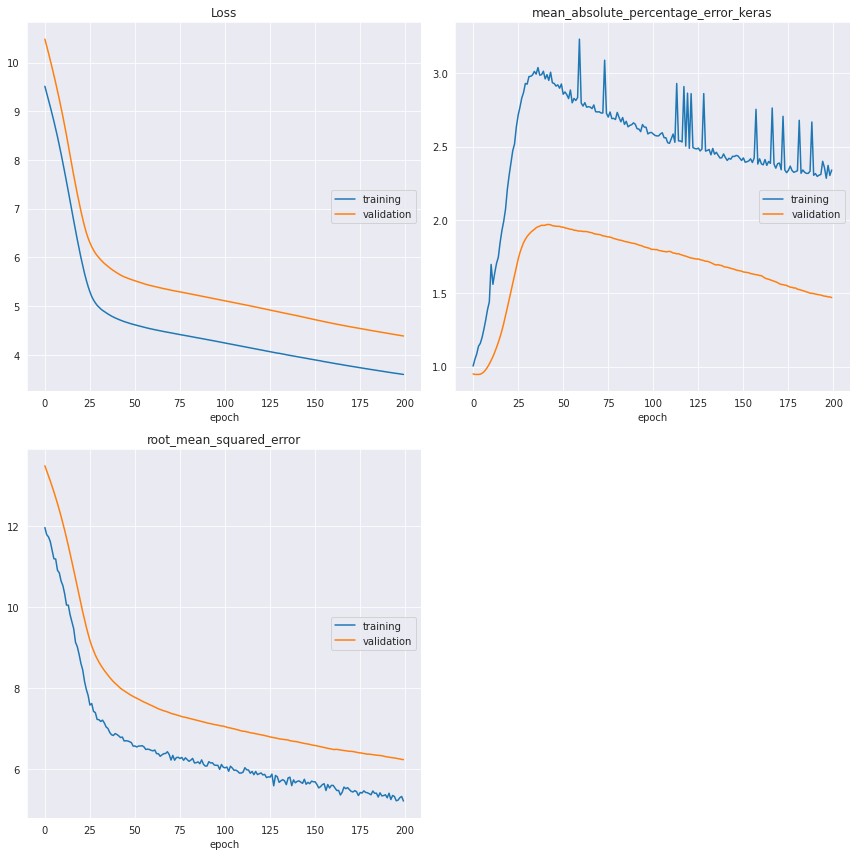

Loss
	training         	 (min:    3.598, max:    9.512, cur:    3.598)
	validation       	 (min:    4.387, max:   10.479, cur:    4.387)
mean_absolute_percentage_error_keras
	training         	 (min:    1.004, max:    3.232, cur:    2.340)
	validation       	 (min:    0.946, max:    1.969, cur:    1.471)
root_mean_squared_error
	training         	 (min:    5.215, max:   11.968, cur:    5.215)
	validation       	 (min:    6.238, max:   13.493, cur:    6.238)


In [18]:
%%email lahoffma.ines@gmail.com --to hoffmann@es.uni-mannheim.de --s '[PyMail] Lambda-Net Training Finished' --keep-password

clf_list = []
chunksize = 1000 if data_size > 10000 else max(data_size//10, min(50, data_size))
X_data_list_splits = list(chunks(X_data_list, chunksize))
y_data_list_splits = list(chunks(y_data_list, chunksize))

for X_data_list_split, y_data_list_split in tqdm(zip(X_data_list_splits, y_data_list_splits), total=max(len(X_data_list_splits), len(y_data_list_splits))):
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    clf_sublist = parallel(delayed(train_nn)(X_data[1].values, y_data[1].values, X_data[0], return_history=True, each_epochs_save=each_epochs_save, printing=True) for X_data, y_data in zip(X_data_list_split, y_data_list_split))  
    clf_list.extend(clf_sublist)
    del parallel
rand_index = np.random.randint(data_size)
random_network = train_nn(X_data_list[rand_index][1], y_data_list[rand_index][1], X_data_list[rand_index][0], callbacks=[PlotLossesKerasTF()], return_model=True)


## Save Lambda-Model scores

In [19]:
if each_epochs_save == None:
    dict_list_train = [clf[1][0] for clf in clf_list]
    dict_list_valid = [clf[1][1] for clf in clf_list]
    dict_list_test = [clf[1][2] for clf in clf_list]
    dict_list_stds = [clf[1][3] for clf in clf_list]
    dict_list_means = [clf[1][4] for clf in clf_list]

    dict_list_train_mean = pd.DataFrame(dict_list_train, columns=dict_list_train[0].keys()).mean()
    df_mean_scores_train = pd.DataFrame(np.column_stack((dict_list_train_mean.values[0::4], dict_list_train_mean.values[1::4], dict_list_train_mean.values[2::4], dict_list_train_mean.values[3::4])), columns=['TRAIN PRED', 'TRAIN POLY', 'TRAIN POLY PRED', 'TRAIN LSTSQ'], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])

    dict_list_valid_mean = pd.DataFrame(dict_list_valid, columns=dict_list_valid[0].keys()).mean()
    df_mean_scores_valid = pd.DataFrame(np.column_stack((dict_list_valid_mean.values[0::4], dict_list_valid_mean.values[1::4], dict_list_valid_mean.values[2::4], dict_list_valid_mean.values[3::4])), columns=['VALID PRED', 'VALID POLY', 'VALID POLY PRED', 'VALID LSTSQ'], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])

    dict_list_test_mean = pd.DataFrame(dict_list_test, columns=dict_list_test[0].keys()).mean()
    df_mean_scores_test = pd.DataFrame(np.column_stack((dict_list_test_mean.values[0::4], dict_list_test_mean.values[1::4], dict_list_test_mean.values[2::4], dict_list_test_mean.values[3::4])), columns=['TEST PRED', 'TEST POLY', 'TEST POLY PRED', 'TEST LSTSQ'], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])

    stds_mean = pd.DataFrame(dict_list_stds, columns=dict_list_stds[0].keys()).mean()
    df_stds = pd.DataFrame(stds_mean, columns=['0'], index=stds_mean.index)
    
    means_mean = pd.DataFrame(dict_list_means, columns=dict_list_means[0].keys()).mean()
    df_means = pd.DataFrame(means_mean, columns=['0'], index=means_mean.index)
    
    path_scores_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_train_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_stds = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_means = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
   
    df_mean_scores_train.to_csv(path_scores_train, sep=',')
    df_mean_scores_valid.to_csv(path_scores_valid, sep=',')
    df_mean_scores_test.to_csv(path_scores_test, sep=',')
    df_stds.to_csv(path_stds, sep=',')
    df_means.to_csv(path_means, sep=',')
else:
    scores_list = [clf[1] for clf in clf_list]
    
    scores_dict_list_by_epochs = [[] for i in range(epochs//each_epochs_save)]
    for scores_dict_list in scores_list:   
        for index, scores_dict in enumerate(scores_dict_list):
            scores_dict_list_by_epochs[index].append(scores_dict)
            
        
    for index, scores_dict_list_single_epoch in enumerate(scores_dict_list_by_epochs):
        index = (index+1)*each_epochs_save
        dict_list_train = [dict_list[0] for dict_list in scores_dict_list_single_epoch]
        dict_list_valid = [dict_list[1] for dict_list in scores_dict_list_single_epoch]
        dict_list_test = [dict_list[2] for dict_list in scores_dict_list_single_epoch]
        dict_list_stds = [dict_list[3] for dict_list in scores_dict_list_single_epoch]
        dict_list_means = [dict_list[4] for dict_list in scores_dict_list_single_epoch]
        
        dict_list_train_mean = pd.DataFrame(dict_list_train, columns=dict_list_train[0].keys()).mean()  
        dict_list_valid_mean = pd.DataFrame(dict_list_valid, columns=dict_list_valid[0].keys()).mean()  
        dict_list_test_mean = pd.DataFrame(dict_list_test, columns=dict_list_test[0].keys()).mean()
        stds_mean = pd.DataFrame(dict_list_stds, columns=dict_list_stds[0].keys()).mean()
        means_mean = pd.DataFrame(dict_list_means, columns=dict_list_means[0].keys()).mean()

        if index == 1*each_epochs_save:
            df_mean_scores_train = pd.DataFrame(np.column_stack((dict_list_train_mean.values[0::4], dict_list_train_mean.values[1::4], dict_list_train_mean.values[2::4], dict_list_train_mean.values[3::4])), columns=['TRAIN PRED E' + str(index), 'TRAIN POLY E' + str(index), 'TRAIN POLY PRED E' + str(index), 'TRAIN LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            df_mean_scores_valid = pd.DataFrame(np.column_stack((dict_list_valid_mean.values[0::4], dict_list_valid_mean.values[1::4], dict_list_valid_mean.values[2::4], dict_list_valid_mean.values[3::4])), columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index), 'VALID POLY PRED E' + str(index), 'VALID LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            df_mean_scores_test = pd.DataFrame(np.column_stack((dict_list_test_mean.values[0::4], dict_list_test_mean.values[1::4], dict_list_test_mean.values[2::4], dict_list_test_mean.values[3::4])), columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index), 'TEST POLY PRED E' + str(index), 'TEST LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            df_stds = pd.DataFrame(stds_mean, columns=['E' + str(index)], index=stds_mean.index)   
            df_means = pd.DataFrame(means_mean, columns=['E' + str(index)], index=means_mean.index)   
        else:
            df_mean_scores_train_new = pd.DataFrame(np.column_stack((dict_list_train_mean.values[0::4], dict_list_train_mean.values[1::4], dict_list_train_mean.values[2::4], dict_list_train_mean.values[3::4])), columns=['TRAIN PRED E' + str(index), 'TRAIN POLY E' + str(index), 'TRAIN POLY PRED E' + str(index), 'TRAIN LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            df_mean_scores_train = pd.concat([df_mean_scores_train, df_mean_scores_train_new],axis=1)  
            
            df_mean_scores_valid_new = pd.DataFrame(np.column_stack((dict_list_valid_mean.values[0::4], dict_list_valid_mean.values[1::4], dict_list_valid_mean.values[2::4], dict_list_valid_mean.values[3::4])), columns=['VALID PRED E' + str(index), 'VALID POLY E' + str(index), 'VALID POLY PRED E' + str(index), 'VALID LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            df_mean_scores_valid = pd.concat([df_mean_scores_valid, df_mean_scores_valid_new],axis=1)  

            df_mean_scores_test_new = pd.DataFrame(np.column_stack((dict_list_test_mean.values[0::4], dict_list_test_mean.values[1::4], dict_list_test_mean.values[2::4], dict_list_test_mean.values[3::4])), columns=['TEST PRED E' + str(index), 'TEST POLY E' + str(index), 'TEST POLY PRED E' + str(index), 'TEST LSTSQ E' + str(index)], index=['MAE FV', 'RMSE FV', 'MAPE FV', 'R2 FV', 'RAAE FV', 'RMAE FV', 'FD FV', 'DTW FV'])
            df_mean_scores_test = pd.concat([df_mean_scores_test, df_mean_scores_test_new],axis=1)  

            df_stds_new = pd.DataFrame(stds_mean, columns=['E' + str(index)], index=stds_mean.index)
            df_stds = pd.concat([df_stds, df_stds_new],axis=1)  
            
            df_means_new = pd.DataFrame(means_mean, columns=['E' + str(index)], index=means_mean.index)
            df_means = pd.concat([df_means, df_means_new],axis=1)     

    path_scores_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_train_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_scores_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/scores_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_stds = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/stds_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_means = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/means_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

    df_mean_scores_train.to_csv(path_scores_train, sep=',')
    df_mean_scores_valid.to_csv(path_scores_valid, sep=',')
    df_mean_scores_test.to_csv(path_scores_test, sep=',')
    df_stds.to_csv(path_stds, sep=',')
    df_means.to_csv(path_means, sep=',')
        

In [20]:
df_mean_scores_train

,TRAIN PRED E5,TRAIN POLY E5,TRAIN POLY PRED E5,TRAIN LSTSQ E5,TRAIN PRED E10,TRAIN POLY E10,TRAIN POLY PRED E10,TRAIN LSTSQ E10,TRAIN PRED E15,TRAIN POLY E15,...,TRAIN POLY PRED E190,TRAIN LSTSQ E190,TRAIN PRED E195,TRAIN POLY E195,TRAIN POLY PRED E195,TRAIN LSTSQ E195,TRAIN PRED E200,TRAIN POLY E200,TRAIN POLY PRED E200,TRAIN LSTSQ E200
MAE FV,9.845,9.845,0.013,0.000,9.566,9.566,0.014,0.000,9.226,9.227,...,0.402,0.000,4.134,4.178,0.415,0.000,4.089,4.133,0.427,0.000
RMSE FV,12.631,12.631,0.016,0.000,12.343,12.343,0.018,0.000,11.992,11.992,...,0.514,0.000,5.862,5.835,0.530,0.000,5.805,5.776,0.546,0.000
MAPE FV,1.123,1.124,0.210,0.000,1.243,1.245,0.132,0.000,1.397,1.401,...,0.553,0.000,2.376,2.476,0.442,0.000,2.352,2.456,0.443,0.000
R2 FV,-0.369,-0.369,0.982,1.000,-0.297,-0.297,0.993,1.000,-0.213,-0.213,...,0.995,1.000,0.686,0.689,0.994,1.000,0.692,0.695,0.994,1.000
RAAE FV,0.901,0.901,0.100,0.000,0.874,0.874,0.062,0.000,0.841,0.841,...,0.054,0.000,0.387,0.391,0.055,0.000,0.383,0.387,0.057,0.000
RMAE FV,3.427,3.426,0.524,0.000,3.408,3.406,0.318,0.000,3.380,3.379,...,0.257,0.000,2.281,2.214,0.262,0.000,2.265,2.196,0.268,0.000
FD FV,24.243,24.241,0.028,0.000,23.825,23.823,0.031,0.000,23.297,23.293,...,0.867,0.000,10.828,10.748,0.894,0.000,10.739,10.658,0.921,0.000
DTW FV,99.889,99.892,0.102,0.000,97.145,97.152,0.113,0.000,93.799,93.807,...,3.707,0.000,40.633,41.158,3.823,0.000,40.183,40.723,3.938,0.000


In [21]:
df_mean_scores_valid

,VALID PRED E5,VALID POLY E5,VALID POLY PRED E5,VALID LSTSQ E5,VALID PRED E10,VALID POLY E10,VALID POLY PRED E10,VALID LSTSQ E10,VALID PRED E15,VALID POLY E15,...,VALID POLY PRED E190,VALID LSTSQ E190,VALID PRED E195,VALID POLY E195,VALID POLY PRED E195,VALID LSTSQ E195,VALID PRED E200,VALID POLY E200,VALID POLY PRED E200,VALID LSTSQ E200
MAE FV,9.986,9.986,0.014,0.000,9.710,9.710,0.014,0.000,9.374,9.374,...,0.426,0.000,4.373,4.388,0.440,0.000,4.330,4.343,0.453,0.000
RMSE FV,12.754,12.754,0.017,0.000,12.469,12.469,0.018,0.000,12.122,12.121,...,0.545,0.000,6.087,6.033,0.562,0.000,6.031,5.974,0.579,0.000
MAPE FV,1.194,1.191,0.187,0.000,1.345,1.344,0.127,0.000,1.535,1.533,...,0.427,0.000,2.711,2.801,0.561,0.000,2.671,2.767,1.248,0.000
R2 FV,-0.372,-0.372,0.978,1.000,-0.303,-0.302,0.992,1.000,-0.220,-0.220,...,0.994,1.000,0.666,0.671,0.994,1.000,0.672,0.677,0.993,1.000
RAAE FV,0.906,0.906,0.112,0.000,0.880,0.880,0.066,0.000,0.848,0.848,...,0.057,0.000,0.406,0.408,0.059,0.000,0.402,0.404,0.060,0.000
RMAE FV,2.929,2.929,0.454,0.000,2.911,2.910,0.271,0.000,2.884,2.884,...,0.226,0.000,1.889,1.836,0.231,0.000,1.876,1.821,0.236,0.000
FD FV,22.535,22.532,0.029,0.000,22.059,22.056,0.032,0.000,21.455,21.450,...,0.900,0.000,9.901,9.867,0.927,0.000,9.812,9.783,0.954,0.000
DTW FV,94.289,94.298,0.134,0.000,91.423,91.436,0.147,0.000,87.962,87.976,...,3.892,0.000,38.115,38.583,4.010,0.000,37.742,38.210,4.125,0.000


In [22]:
df_mean_scores_test

,TEST PRED E5,TEST POLY E5,TEST POLY PRED E5,TEST LSTSQ E5,TEST PRED E10,TEST POLY E10,TEST POLY PRED E10,TEST LSTSQ E10,TEST PRED E15,TEST POLY E15,...,TEST POLY PRED E190,TEST LSTSQ E190,TEST PRED E195,TEST POLY E195,TEST POLY PRED E195,TEST LSTSQ E195,TEST PRED E200,TEST POLY E200,TEST POLY PRED E200,TEST LSTSQ E200
MAE FV,9.864,9.864,0.013,0.000,9.587,9.587,0.014,0.000,9.251,9.251,...,0.424,0.000,4.218,4.243,0.438,0.000,4.175,4.200,0.451,0.000
RMSE FV,12.567,12.567,0.017,0.000,12.278,12.277,0.018,0.000,11.925,11.924,...,0.543,0.000,5.860,5.821,0.559,0.000,5.805,5.763,0.576,0.000
MAPE FV,1.157,1.155,0.232,0.000,1.333,1.332,0.117,0.000,1.584,1.584,...,0.426,0.000,3.062,3.108,0.527,0.000,3.037,3.076,0.534,0.000
R2 FV,-0.380,-0.380,0.982,1.000,-0.308,-0.307,0.993,1.000,-0.222,-0.222,...,0.994,1.000,0.680,0.683,0.994,1.000,0.685,0.689,0.993,1.000
RAAE FV,0.911,0.911,0.099,0.000,0.884,0.884,0.063,0.000,0.851,0.851,...,0.057,0.000,0.399,0.401,0.058,0.000,0.395,0.397,0.060,0.000
RMAE FV,3.068,3.067,0.516,0.000,3.048,3.047,0.331,0.000,3.020,3.019,...,0.250,0.000,1.967,1.912,0.255,0.000,1.953,1.896,0.261,0.000
FD FV,24.642,24.639,0.026,0.000,24.181,24.173,0.033,0.000,23.596,23.586,...,1.081,0.000,10.441,10.332,1.114,0.000,10.349,10.237,1.148,0.000
DTW FV,100.029,100.019,0.129,0.000,97.262,97.238,0.145,0.000,93.920,93.892,...,4.124,0.000,40.205,40.433,4.253,0.000,39.786,40.018,4.382,0.000


In [23]:
df_stds

,E5,E10,E15,E20,E25,E30,E35,E40,E45,E50,...,E155,E160,E165,E170,E175,E180,E185,E190,E195,E200
STD FV TRAIN REAL,11.047,11.047,11.047,11.047,11.047,11.047,11.047,11.047,11.047,11.047,...,11.047,11.047,11.047,11.047,11.047,11.047,11.047,11.047,11.047,11.047
STD FV VALID REAL,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,...,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132
STD FV VALID PRED,0.132,0.232,0.379,0.594,0.907,1.333,1.852,2.418,2.994,3.555,...,7.705,7.748,7.790,7.831,7.871,7.911,7.949,7.987,8.025,8.063
STD FV VALID POLY,0.130,0.231,0.379,0.594,0.907,1.333,1.852,2.419,2.994,3.555,...,7.698,7.740,7.782,7.822,7.861,7.900,7.937,7.974,8.011,8.049
STD FV VALID LSTSQ,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,...,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132,11.132
STD FV TEST REAL,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,...,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946
STD FV TEST PRED,0.135,0.235,0.382,0.597,0.910,1.337,1.856,2.425,3.003,3.566,...,7.707,7.748,7.789,7.829,7.868,7.907,7.944,7.981,8.018,8.055
STD FV TEST POLY,0.136,0.236,0.383,0.598,0.911,1.338,1.857,2.426,3.004,3.568,...,7.704,7.745,7.784,7.823,7.861,7.898,7.935,7.970,8.006,8.042
STD FV TEST LSTSQ,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,...,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946,10.946


In [24]:
df_means

,E5,E10,E15,E20,E25,E30,E35,E40,E45,E50,...,E155,E160,E165,E170,E175,E180,E185,E190,E195,E200
MEAN FV TRAIN REAL,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137,...,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137
MEAN FV VALID REAL,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,...,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112
MEAN FV VALID PRED,0.198,0.232,0.298,0.403,0.512,0.567,0.550,0.489,0.424,0.368,...,0.193,0.194,0.194,0.194,0.195,0.197,0.198,0.198,0.198,0.197
MEAN FV VALID POLY,0.197,0.231,0.297,0.402,0.511,0.566,0.549,0.488,0.423,0.367,...,0.191,0.192,0.192,0.192,0.194,0.195,0.196,0.197,0.196,0.195
MEAN FV VALID LSTSQ,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,...,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112,0.112
MEAN FV TEST REAL,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,...,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136
MEAN FV TEST PRED,0.197,0.232,0.299,0.406,0.518,0.575,0.561,0.501,0.437,0.383,...,0.219,0.220,0.220,0.220,0.222,0.223,0.224,0.225,0.225,0.224
MEAN FV TEST POLY,0.197,0.232,0.300,0.407,0.518,0.575,0.561,0.501,0.437,0.382,...,0.217,0.217,0.217,0.218,0.219,0.220,0.221,0.222,0.222,0.221
MEAN FV TEST LSTSQ,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,...,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136,0.136


In [25]:
if each_epochs_save == None:
    polynomials = [clf[0][0] for clf in clf_list]
    polynomial_pred_lists = [clf[0][1] for clf in clf_list]
    polynomial_lstsq_true_lists = [clf[0][2] for clf in clf_list]
    
    polynomials_df = pd.DataFrame(polynomials)
    
    pred_evaluation_dataset_train_real, pred_evaluation_dataset_train, pred_evaluation_dataset_train_polynomial, X_train_data, pred_evaluation_dataset_valid_real, pred_evaluation_dataset_valid, pred_evaluation_dataset_valid_polynomial, X_valid_data, pred_evaluation_dataset_test_real, pred_evaluation_dataset_test, pred_evaluation_dataset_test_polynomial, X_test_data = [clf[2] for clf in clf_list]

    pred_evaluation_dataset_train_real = pred_evaluation_dataset_train_real.ravel()
    pred_evaluation_dataset_valid_real = pred_evaluation_dataset_valid_real.ravel()
    pred_evaluation_dataset_test_real = pred_evaluation_dataset_test_real.ravel()
    pred_evaluation_dataset_train = pred_evaluation_dataset_train.ravel()
    pred_evaluation_dataset_valid = pred_evaluation_dataset_valid.ravel()
    pred_evaluation_dataset_test = pred_evaluation_dataset_test.ravel()
    pred_evaluation_dataset_train_polynomial = pred_evaluation_dataset_train_polynomial.ravel()
    pred_evaluation_dataset_valid_polynomial = pred_evaluation_dataset_valid_polynomial.ravel()
    pred_evaluation_dataset_test_polynomial = pred_evaluation_dataset_test_polynomial.ravel()
    
    pred_evaluation_dataset_valid_real_df = pd.DataFrame(pred_evaluation_dataset_train_real, columns=[str(train_data) for train_data in X_train_data])
    pred_evaluation_dataset_train_real_df = pd.DataFrame(pred_evaluation_dataset_valid_real, columns=[str(valid_data) for valid_data in X_valid_data])
    pred_evaluation_dataset_test_real_df = pd.DataFrame(pred_evaluation_dataset_test_real, columns=[str(test_data) for test_data in X_test_data])
    pred_evaluation_dataset_train_df = pd.DataFrame(pred_evaluation_dataset_train, columns=[str(train_data) for train_data in X_vtrain_data])
    pred_evaluation_dataset_valid_df = pd.DataFrame(pred_evaluation_dataset_valid, columns=[str(valid_data) for valid_data in X_valid_data])
    pred_evaluation_dataset_test_df = pd.DataFrame(pred_evaluation_dataset_test, columns=[str(test_data) for test_data in X_test_data])
    pred_evaluation_dataset_train_polynomial_df = pd.DataFrame(pred_evaluation_dataset_train_polynomial, columns=[str(train_data) for train_data in X_train_data])
    pred_evaluation_dataset_valid_polynomial_df = pd.DataFrame(pred_evaluation_dataset_valid_polynomial, columns=[str(valid_data) for valid_data in X_valid_data])
    pred_evaluation_dataset_test_polynomial_df = pd.DataFrame(pred_evaluation_dataset_test_polynomial, columns=[str(test_data) for test_data in X_test_data])    
    
    pred_evaluation_dataset_train_real_df = pd.concat([polynomials_df, pred_evaluation_dataset_train_real_df], axis=1)
    pred_evaluation_dataset_valid_real_df = pd.concat([polynomials_df, pred_evaluation_dataset_valid_real_df], axis=1)
    pred_evaluation_dataset_test_real_df = pd.concat([polynomials_df, pred_evaluation_dataset_test_real_df], axis=1)
    pred_evaluation_dataset_train_df = pd.concat([polynomials_df, pred_evaluation_dataset_train_df], axis=1)
    pred_evaluation_dataset_valid_df = pd.concat([polynomials_df, pred_evaluation_dataset_valid_df], axis=1)
    pred_evaluation_dataset_test_df = pd.concat([polynomials_df, pred_evaluation_dataset_test_df], axis=1)
    pred_evaluation_dataset_train_polynomial_df = pd.concat([polynomials_df, pred_evaluation_dataset_train_polynomial_df], axis=1)
    pred_evaluation_dataset_valid_polynomial_df = pd.concat([polynomials_df, pred_evaluation_dataset_valid_polynomial_df], axis=1)
    pred_evaluation_dataset_test_polynomial_df = pd.concat([polynomials_df, pred_evaluation_dataset_test_polynomial_df], axis=1)
       
    path_pred_evaluation_dataset_train_real = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_real_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_valid_real = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_real_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_test_real = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_real_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_train_polynomial = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_polynomial_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_valid_polynomial = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_polynomial_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
    path_pred_evaluation_dataset_test_polynomial = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_polynomial_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
   
    pred_evaluation_dataset_train_real_df.to_csv(path_pred_evaluation_dataset_train_real, sep=',', index=False)
    pred_evaluation_dataset_valid_real_df.to_csv(path_pred_evaluation_dataset_valid_real, sep=',', index=False)
    pred_evaluation_dataset_test_real_df.to_csv(path_pred_evaluation_dataset_test_real, sep=',', index=False)
    pred_evaluation_dataset_train_df.to_csv(path_pred_evaluation_dataset_train, sep=',', index=False)
    pred_evaluation_dataset_valid_df.to_csv(path_pred_evaluation_dataset_valid, sep=',', index=False)
    pred_evaluation_dataset_test_df.to_csv(path_pred_evaluation_dataset_test, sep=',', index=False)
    pred_evaluation_dataset_train_polynomial_df.to_csv(path_pred_evaluation_dataset_train_polynomial, sep=',', index=False)
    pred_evaluation_dataset_valid_polynomial_df.to_csv(path_pred_evaluation_dataset_valid_polynomial, sep=',', index=False)
    pred_evaluation_dataset_test_polynomial_df.to_csv(path_pred_evaluation_dataset_test_polynomial, sep=',', index=False)
    
else:
    
    polynomials = [clf[0][0] for clf in clf_list]
    polynomial_pred_lists = [clf[0][1] for clf in clf_list]
    polynomial_lstsq_true_lists = [clf[0][2] for clf in clf_list]
    
    polynomials_df = pd.DataFrame(polynomials)
    
    pred_evaluation_dataset_train_real_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][0]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_train_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][1]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_train_polynomial_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][2]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_valid_real_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][4]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_valid_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][5]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_valid_polynomial_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][6]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_test_real_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][8]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_test_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][9]))) for i in range(epochs//each_epochs_save)]
    pred_evaluation_dataset_test_polynomial_list = [np.zeros((len(clf_list), len(clf_list[0][2][0][10]))) for i in range(epochs//each_epochs_save)]
    
    for i, pred_evaluation_dataset_per_epoch in tqdm(enumerate([clf[2] for clf in clf_list]), total=len(clf_list)):
        
        for index, (pred_evaluation_dataset_train_real, pred_evaluation_dataset_train, pred_evaluation_dataset_train_polynomial, X_train_data, pred_evaluation_dataset_valid_real, pred_evaluation_dataset_valid, pred_evaluation_dataset_valid_polynomial, X_valid_data, pred_evaluation_dataset_test_real, pred_evaluation_dataset_test, pred_evaluation_dataset_test_polynomial, X_test_data) in enumerate(pred_evaluation_dataset_per_epoch):
            pred_evaluation_dataset_train_real_list[index][i] = pred_evaluation_dataset_train_real.ravel()
            pred_evaluation_dataset_train_list[index][i] = pred_evaluation_dataset_train.ravel()
            pred_evaluation_dataset_train_polynomial_list[index][i] = pred_evaluation_dataset_train_polynomial.ravel()
            
            pred_evaluation_dataset_valid_real_list[index][i] = pred_evaluation_dataset_valid_real.ravel()
            pred_evaluation_dataset_valid_list[index][i] = pred_evaluation_dataset_valid.ravel()
            pred_evaluation_dataset_valid_polynomial_list[index][i] = pred_evaluation_dataset_valid_polynomial.ravel()
            
            pred_evaluation_dataset_test_real_list[index][i] = pred_evaluation_dataset_test_real.ravel()
            pred_evaluation_dataset_test_list[index][i] = pred_evaluation_dataset_test.ravel()
            pred_evaluation_dataset_test_polynomial_list[index][i] = pred_evaluation_dataset_test_polynomial.ravel()
    
    for index, (pred_evaluation_dataset_train_real_by_epoch, pred_evaluation_dataset_train_by_epoch, pred_evaluation_dataset_train_polynomial_by_epoch, pred_evaluation_dataset_valid_real_by_epoch, pred_evaluation_dataset_valid_by_epoch, pred_evaluation_dataset_valid_polynomial_by_epoch, pred_evaluation_dataset_test_real_by_epoch, pred_evaluation_dataset_test_by_epoch, pred_evaluation_dataset_test_polynomial_by_epoch) in tqdm(enumerate(zip(pred_evaluation_dataset_train_real_list, pred_evaluation_dataset_train_list, pred_evaluation_dataset_train_polynomial_list, pred_evaluation_dataset_valid_real_list, pred_evaluation_dataset_valid_list, pred_evaluation_dataset_valid_polynomial_list, pred_evaluation_dataset_test_real_list, pred_evaluation_dataset_test_list, pred_evaluation_dataset_test_polynomial_list)), total=len(pred_evaluation_dataset_valid_list)):
        
        pred_evaluation_dataset_train_real_df = pd.DataFrame(pred_evaluation_dataset_train_real_by_epoch, columns=[str(train_data) for train_data in X_train_data])
        pred_evaluation_dataset_train_df = pd.DataFrame(pred_evaluation_dataset_train_by_epoch, columns=[str(train_data) for train_data in X_train_data])
        pred_evaluation_dataset_train_polynomial_df = pd.DataFrame(pred_evaluation_dataset_train_polynomial_by_epoch, columns=[str(train_data) for train_data in X_train_data])  
        pred_evaluation_dataset_valid_real_df = pd.DataFrame(pred_evaluation_dataset_valid_real_by_epoch, columns=[str(valid_data) for valid_data in X_valid_data])
        pred_evaluation_dataset_valid_df = pd.DataFrame(pred_evaluation_dataset_valid_by_epoch, columns=[str(valid_data) for valid_data in X_valid_data])
        pred_evaluation_dataset_valid_polynomial_df = pd.DataFrame(pred_evaluation_dataset_valid_polynomial_by_epoch, columns=[str(valid_data) for valid_data in X_valid_data])  
        pred_evaluation_dataset_test_real_df = pd.DataFrame(pred_evaluation_dataset_test_real_by_epoch, columns=[str(test_data) for test_data in X_test_data])
        pred_evaluation_dataset_test_df = pd.DataFrame(pred_evaluation_dataset_test_by_epoch, columns=[str(test_data) for test_data in X_test_data])
        pred_evaluation_dataset_test_polynomial_df = pd.DataFrame(pred_evaluation_dataset_test_polynomial_by_epoch, columns=[str(test_data) for test_data in X_test_data])   
        
        pred_evaluation_dataset_train_real_df = pd.concat([polynomials_df, pred_evaluation_dataset_train_real_df], axis=1)
        pred_evaluation_dataset_valid_real_df = pd.concat([polynomials_df, pred_evaluation_dataset_valid_real_df], axis=1)
        pred_evaluation_dataset_test_real_df = pd.concat([polynomials_df, pred_evaluation_dataset_test_real_df], axis=1)
        pred_evaluation_dataset_train_df = pd.concat([polynomials_df, pred_evaluation_dataset_train_df], axis=1)
        pred_evaluation_dataset_valid_df = pd.concat([polynomials_df, pred_evaluation_dataset_valid_df], axis=1)
        pred_evaluation_dataset_test_df = pd.concat([polynomials_df, pred_evaluation_dataset_test_df], axis=1)
        pred_evaluation_dataset_train_polynomial_df = pd.concat([polynomials_df, pred_evaluation_dataset_train_polynomial_df], axis=1)
        pred_evaluation_dataset_valid_polynomial_df = pd.concat([polynomials_df, pred_evaluation_dataset_valid_polynomial_df], axis=1)
        pred_evaluation_dataset_test_polynomial_df = pd.concat([polynomials_df, pred_evaluation_dataset_test_polynomial_df], axis=1)

        path_pred_evaluation_dataset_train_real = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_real_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_valid_real = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_real_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_test_real = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_real_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_train = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_valid = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_test = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_train_polynomial = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_train_polynomial_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_valid_polynomial = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_valid_polynomial_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
        path_pred_evaluation_dataset_test_polynomial = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/pred_evaluation_dataset_test_polynomial_' + 'epoch_' + str(index).zfill(3) + '_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

        pred_evaluation_dataset_train_real_df.to_csv(path_pred_evaluation_dataset_train_real, sep=',', index=False)
        pred_evaluation_dataset_valid_real_df.to_csv(path_pred_evaluation_dataset_valid_real, sep=',', index=False)
        pred_evaluation_dataset_test_real_df.to_csv(path_pred_evaluation_dataset_test_real, sep=',', index=False)         
        pred_evaluation_dataset_train_df.to_csv(path_pred_evaluation_dataset_train, sep=',', index=False)
        pred_evaluation_dataset_valid_df.to_csv(path_pred_evaluation_dataset_valid, sep=',', index=False)
        pred_evaluation_dataset_test_df.to_csv(path_pred_evaluation_dataset_test, sep=',', index=False)    
        pred_evaluation_dataset_train_polynomial_df.to_csv(path_pred_evaluation_dataset_train_polynomial, sep=',', index=False)
        pred_evaluation_dataset_valid_polynomial_df.to_csv(path_pred_evaluation_dataset_valid_polynomial, sep=',', index=False)
        pred_evaluation_dataset_test_polynomial_df.to_csv(path_pred_evaluation_dataset_test_polynomial, sep=',', index=False) 


<ipython-input-25-59a7d38c93eb>:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, pred_evaluation_dataset_per_epoch in tqdm(enumerate([clf[2] for clf in clf_list]), total=len(clf_list)):


<ipython-input-25-59a7d38c93eb>:93: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index, (pred_evaluation_dataset_train_real_by_epoch, pred_evaluation_dataset_train_by_epoch, pred_evaluation_dataset_train_polynomial_by_epoch, pred_evaluation_dataset_valid_real_by_epoch, pred_evaluation_dataset_valid_by_epoch, pred_evaluation_dataset_valid_polynomial_by_epoch, pred_evaluation_dataset_test_real_by_epoch, pred_evaluation_dataset_test_by_epoch, pred_evaluation_dataset_test_polynomial_by_epoch) in tqdm(enumerate(zip(pred_evaluation_dataset_train_real_list, pred_evaluation_dataset_train_list, pred_evaluation_dataset_train_polynomial_list, pred_evaluation_dataset_valid_real_list, pred_evaluation_dataset_valid_list, pred_evaluation_dataset_valid_polynomial_list, pred_evaluation_dataset_test_real_list, pred_evaluation_dataset_test_list, pred_evaluation_dataset_test_polynomial_list)), total=len(pred_eval

In [57]:
pred_evaluation_dataset_valid_real_df

,0000,0001,0002,0003,0010,0011,0012,0020,0021,0030,...,[ 0.54 -0.36 -0.65 -0.15],[ 0.19 0.09 0.49 -0.57],[ 0.31 -0.14 -0.14 -0.53],[ 0.63 0.3 -0.16 0.07],[ 0.53 0.2 -0.94 0.75],[-0.42 0.68 -0.47 -0.49],[ 0.09 0.01 0.24 -0.88],[ 0.68 -0.84 0.97 -0.29],[ 0.44 -0.38 0.65 0.78],[-0.86 -0.01 0.96 0.45]
0,6.300,-7.200,-9.400,8.900,-3.000,-3.800,-4.300,-6.500,8.800,-7.400,...,2.053,-1.037,4.667,7.981,17.877,10.108,-2.843,-35.324,-22.465,1.251
1,-9.900,9.400,-6.000,7.800,0.800,-1.300,-2.900,-6.100,-4.500,9.500,...,-12.242,-17.358,-15.759,-4.426,-11.355,-28.500,-27.527,-24.286,1.330,0.626
2,-8.900,6.900,-4.200,9.700,-2.600,-8.000,-4.100,-7.500,-0.300,-2.900,...,-12.951,-18.182,-14.672,1.023,6.637,-14.289,-25.483,-27.545,-10.465,-37.682
3,4.200,-4.400,7.500,-1.700,9.600,9.800,-8.600,-4.200,-9.200,-2.000,...,-3.982,8.327,7.513,2.569,-10.336,11.018,13.244,3.942,8.238,15.669
4,0.200,-0.800,-4.400,-6.500,3.000,2.600,-7.700,9.300,-8.800,-7.200,...,7.215,3.719,1.881,3.211,5.916,-6.406,1.493,1.742,-7.037,4.807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.100,-7.700,-1.400,-0.200,6.700,-5.400,0.800,-6.200,-2.800,-2.100,...,-2.255,9.222,5.440,0.093,-6.967,-9.329,10.388,-1.525,-14.721,-19.644
496,2.900,-0.200,7.500,1.600,-9.800,2.400,6.700,7.100,0.200,0.800,...,6.252,5.249,6.221,11.532,19.397,18.871,7.631,-1.640,16.115,0.938
497,-8.000,-6.200,-9.900,-1.400,8.100,5.100,-3.400,-5.000,3.100,5.700,...,-22.505,-3.818,-6.962,-8.111,-42.547,-2.831,-8.025,2.819,-16.974,8.344
498,-2.500,-0.900,0.600,-9.600,1.400,-1.700,-2.400,6.200,-9.100,5.200,...,-1.368,6.021,1.170,-0.508,-8.297,-1.868,7.185,41.620,-4.349,-3.170


In [58]:
pred_evaluation_dataset_valid_df

,0000,0001,0002,0003,0010,0011,0012,0020,0021,0030,...,[ 0.54 -0.36 -0.65 -0.15],[ 0.19 0.09 0.49 -0.57],[ 0.31 -0.14 -0.14 -0.53],[ 0.63 0.3 -0.16 0.07],[ 0.53 0.2 -0.94 0.75],[-0.42 0.68 -0.47 -0.49],[ 0.09 0.01 0.24 -0.88],[ 0.68 -0.84 0.97 -0.29],[ 0.44 -0.38 0.65 0.78],[-0.86 -0.01 0.96 0.45]
0,6.300,-7.200,-9.400,8.900,-3.000,-3.800,-4.300,-6.500,8.800,-7.400,...,3.692,-2.203,2.486,5.450,9.484,8.773,1.008,-18.103,-19.749,-5.314
1,-9.900,9.400,-6.000,7.800,0.800,-1.300,-2.900,-6.100,-4.500,9.500,...,-12.617,-20.127,-20.626,-8.356,-4.783,-29.874,-27.733,-10.627,-0.121,-8.043
2,-8.900,6.900,-4.200,9.700,-2.600,-8.000,-4.100,-7.500,-0.300,-2.900,...,-10.894,-21.447,-19.140,-3.476,8.628,-13.647,-24.337,-24.695,-8.498,-22.892
3,4.200,-4.400,7.500,-1.700,9.600,9.800,-8.600,-4.200,-9.200,-2.000,...,-1.817,10.107,7.483,3.636,-11.922,4.975,11.538,10.601,7.714,10.169
4,0.200,-0.800,-4.400,-6.500,3.000,2.600,-7.700,9.300,-8.800,-7.200,...,5.636,6.074,6.092,4.787,-2.191,1.284,6.706,4.480,-3.478,-3.858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.100,-7.700,-1.400,-0.200,6.700,-5.400,0.800,-6.200,-2.800,-2.100,...,-2.960,8.653,7.091,0.946,-10.202,-6.897,10.758,3.634,-14.543,-9.020
496,2.900,-0.200,7.500,1.600,-9.800,2.400,6.700,7.100,0.200,0.800,...,9.572,9.871,8.799,16.301,15.747,18.858,10.466,-0.107,4.942,-1.550
497,-8.000,-6.200,-9.900,-1.400,8.100,5.100,-3.400,-5.000,3.100,5.700,...,-25.849,-0.551,-6.451,-11.873,-39.551,-3.007,-2.432,-2.656,-16.648,-2.982
498,-2.500,-0.900,0.600,-9.600,1.400,-1.700,-2.400,6.200,-9.100,5.200,...,0.955,7.698,4.759,-0.187,-3.965,-5.827,7.623,26.231,5.241,-7.269


In [59]:
pred_evaluation_dataset_valid_polynomial_df

,0000,0001,0002,0003,0010,0011,0012,0020,0021,0030,...,[ 0.54 -0.36 -0.65 -0.15],[ 0.19 0.09 0.49 -0.57],[ 0.31 -0.14 -0.14 -0.53],[ 0.63 0.3 -0.16 0.07],[ 0.53 0.2 -0.94 0.75],[-0.42 0.68 -0.47 -0.49],[ 0.09 0.01 0.24 -0.88],[ 0.68 -0.84 0.97 -0.29],[ 0.44 -0.38 0.65 0.78],[-0.86 -0.01 0.96 0.45]
0,6.300,-7.200,-9.400,8.900,-3.000,-3.800,-4.300,-6.500,8.800,-7.400,...,2.918,-1.778,2.272,4.022,10.802,9.615,1.283,-18.217,-18.587,-5.749
1,-9.900,9.400,-6.000,7.800,0.800,-1.300,-2.900,-6.100,-4.500,9.500,...,-12.450,-19.843,-20.068,-9.845,-4.659,-29.727,-27.834,-12.208,0.281,-7.276
2,-8.900,6.900,-4.200,9.700,-2.600,-8.000,-4.100,-7.500,-0.300,-2.900,...,-10.698,-21.591,-18.135,-3.749,9.527,-13.344,-24.774,-25.314,-8.372,-23.930
3,4.200,-4.400,7.500,-1.700,9.600,9.800,-8.600,-4.200,-9.200,-2.000,...,-1.568,11.199,6.850,3.173,-11.667,4.660,12.429,9.535,7.732,9.759
4,0.200,-0.800,-4.400,-6.500,3.000,2.600,-7.700,9.300,-8.800,-7.200,...,5.468,6.361,6.492,3.930,-1.780,1.570,7.254,4.270,-3.447,-3.301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.100,-7.700,-1.400,-0.200,6.700,-5.400,0.800,-6.200,-2.800,-2.100,...,-3.241,8.431,5.086,0.787,-9.952,-6.001,10.502,3.813,-13.464,-9.456
496,2.900,-0.200,7.500,1.600,-9.800,2.400,6.700,7.100,0.200,0.800,...,9.985,9.110,8.864,16.272,16.398,18.361,9.363,-0.025,4.851,-2.471
497,-8.000,-6.200,-9.900,-1.400,8.100,5.100,-3.400,-5.000,3.100,5.700,...,-24.779,-0.498,-7.938,-11.803,-40.495,-3.706,-2.168,-3.430,-16.462,-1.369
498,-2.500,-0.900,0.600,-9.600,1.400,-1.700,-2.400,6.200,-9.100,5.200,...,2.223,6.687,5.124,0.509,-5.173,-6.176,6.835,28.986,4.895,-7.648


In [29]:
#variable_values = []
#for column in pred_evaluation_dataset_df.columns:
#    variable_values.append(np.array(column[1:-1].split()).astype('float'))
#variable_values = np.array(variable_values)

In [30]:
#fv_with_vv = []
#for function_values in tqdm(pred_evaluation_dataset_df.values):
#    fv_with_vv.append(np.array([np.append(vv, fv) for fv, vv in zip(function_values, variable_values)]))
#fv_with_vv = np.array(fv_with_vv)

In [31]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

for _, entry in tqdm(enumerate(clf_list)):
    entry = entry[3]
    loss_list = []
    metric_list = []
    val_loss_list = []
    val_metric_list = []
    for i in range(epochs):  
        loss_list.append(entry['loss'][i])
        metric_list.append(entry['mean_absolute_percentage_error_keras'][i])
        val_loss_list.append(entry['val_loss'][i])
        val_metric_list.append(entry['val_mean_absolute_percentage_error_keras'][i])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=loss_list_total, columns=['loss_epoch_' + str(i+1) for i in range(epochs)])
metric_df = pd.DataFrame(data=metric_list_total, columns=['metric_epoch_' + str(i+1) for i in range(epochs)]) 
val_loss_df = pd.DataFrame(data=val_loss_list_total, columns=['val_loss_epoch_' + str(i+1) for i in range(epochs)])
val_metric_df = pd.DataFrame(data=val_metric_list_total, columns=['val_metric_epoch_' + str(i+1) for i in range(epochs)]) 


<ipython-input-31-b23760cfb23d>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, entry in tqdm(enumerate(clf_list)):


In [32]:
path_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
path_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
path_val_loss = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_loss_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'
path_val_metric = './data/weights/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/history_val_metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [33]:
loss_df.describe()

,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,...,loss_epoch_191,loss_epoch_192,loss_epoch_193,loss_epoch_194,loss_epoch_195,loss_epoch_196,loss_epoch_197,loss_epoch_198,loss_epoch_199,loss_epoch_200
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,...,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,10.080,10.029,9.978,9.926,9.874,9.822,9.769,9.714,9.658,9.600,...,4.179,4.170,4.161,4.152,4.143,4.134,4.125,4.116,4.107,4.098
std,2.357,2.333,2.310,2.287,2.264,2.240,2.216,2.190,2.165,2.138,...,0.494,0.493,0.492,0.492,0.491,0.491,0.490,0.489,0.489,0.488
min,5.093,5.088,5.084,5.080,5.077,5.073,5.069,5.065,5.061,5.058,...,2.836,2.831,2.826,2.822,2.816,2.810,2.806,2.801,2.797,2.792
25%,8.313,8.290,8.254,8.223,8.201,8.147,8.089,8.025,7.992,7.911,...,3.809,3.799,3.791,3.783,3.775,3.768,3.761,3.755,3.746,3.738
50%,9.752,9.686,9.633,9.573,9.516,9.478,9.429,9.358,9.322,9.291,...,4.165,4.155,4.144,4.132,4.123,4.111,4.098,4.088,4.082,4.075
75%,11.698,11.636,11.557,11.472,11.390,11.318,11.219,11.147,11.070,10.990,...,4.487,4.476,4.467,4.457,4.448,4.441,4.434,4.422,4.416,4.406
max,18.917,18.807,18.697,18.587,18.476,18.363,18.249,18.131,18.008,17.880,...,5.635,5.624,5.612,5.599,5.587,5.574,5.562,5.550,5.537,5.524


In [34]:
val_loss_df.describe()

,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,...,val_loss_epoch_191,val_loss_epoch_192,val_loss_epoch_193,val_loss_epoch_194,val_loss_epoch_195,val_loss_epoch_196,val_loss_epoch_197,val_loss_epoch_198,val_loss_epoch_199,val_loss_epoch_200
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,...,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,10.190,10.140,10.089,10.038,9.986,9.934,9.880,9.825,9.769,9.710,...,4.408,4.399,4.390,4.382,4.373,4.364,4.356,4.347,4.338,4.330
std,2.451,2.428,2.405,2.382,2.358,2.335,2.310,2.285,2.259,2.232,...,0.584,0.583,0.583,0.582,0.581,0.580,0.579,0.578,0.578,0.577
min,5.188,5.175,5.161,5.148,5.134,5.121,5.107,5.093,5.080,5.066,...,3.063,3.051,3.039,3.028,3.017,3.007,2.996,2.984,2.973,2.962
25%,8.376,8.334,8.300,8.272,8.247,8.210,8.178,8.146,8.105,8.025,...,3.967,3.955,3.948,3.942,3.932,3.926,3.920,3.912,3.905,3.899
50%,9.837,9.809,9.783,9.746,9.685,9.640,9.594,9.554,9.495,9.441,...,4.385,4.373,4.365,4.359,4.351,4.339,4.330,4.322,4.311,4.297
75%,11.743,11.657,11.559,11.490,11.447,11.328,11.246,11.196,11.110,11.050,...,4.801,4.791,4.780,4.773,4.767,4.756,4.747,4.736,4.728,4.719
max,19.023,18.912,18.802,18.690,18.578,18.464,18.346,18.226,18.101,17.968,...,6.411,6.405,6.398,6.392,6.387,6.384,6.378,6.371,6.366,6.361


In [35]:
metric_df.describe()

,metric_epoch_1,metric_epoch_2,metric_epoch_3,metric_epoch_4,metric_epoch_5,metric_epoch_6,metric_epoch_7,metric_epoch_8,metric_epoch_9,metric_epoch_10,...,metric_epoch_191,metric_epoch_192,metric_epoch_193,metric_epoch_194,metric_epoch_195,metric_epoch_196,metric_epoch_197,metric_epoch_198,metric_epoch_199,metric_epoch_200
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,...,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,1.074,1.073,1.081,1.093,1.113,1.132,1.156,1.180,1.199,1.229,...,2.392,2.386,2.394,2.377,2.377,2.370,2.363,2.371,2.352,2.352
std,0.161,0.196,0.259,0.279,0.337,0.411,0.491,0.590,0.602,0.675,...,3.954,3.890,3.960,3.902,3.905,3.928,3.858,3.925,3.860,3.864
min,0.966,0.953,0.940,0.933,0.923,0.914,0.901,0.884,0.869,0.860,...,0.333,0.328,0.326,0.329,0.327,0.327,0.321,0.320,0.322,0.321
25%,1.013,1.005,1.001,0.999,0.999,1.000,1.000,1.002,1.004,1.006,...,1.203,1.173,1.171,1.168,1.173,1.181,1.165,1.155,1.163,1.166
50%,1.032,1.023,1.020,1.021,1.027,1.033,1.041,1.051,1.059,1.068,...,1.614,1.611,1.615,1.607,1.606,1.602,1.600,1.592,1.591,1.598
75%,1.069,1.067,1.072,1.080,1.100,1.120,1.133,1.153,1.169,1.194,...,2.396,2.347,2.367,2.360,2.386,2.372,2.337,2.352,2.350,2.359
max,2.598,3.568,5.232,5.123,5.827,6.608,7.832,10.251,9.367,10.054,...,57.032,55.876,56.527,55.907,55.908,56.149,54.964,55.598,55.066,55.107


In [36]:
val_metric_df.describe()

,val_metric_epoch_1,val_metric_epoch_2,val_metric_epoch_3,val_metric_epoch_4,val_metric_epoch_5,val_metric_epoch_6,val_metric_epoch_7,val_metric_epoch_8,val_metric_epoch_9,val_metric_epoch_10,...,val_metric_epoch_191,val_metric_epoch_192,val_metric_epoch_193,val_metric_epoch_194,val_metric_epoch_195,val_metric_epoch_196,val_metric_epoch_197,val_metric_epoch_198,val_metric_epoch_199,val_metric_epoch_200
count,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,...,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000,500.000
mean,1.121,1.132,1.151,1.173,1.199,1.226,1.256,1.287,1.319,1.353,...,2.758,2.751,2.743,2.737,2.726,2.717,2.712,2.703,2.697,2.686
std,1.225,1.447,1.667,1.892,2.120,2.348,2.585,2.821,3.052,3.291,...,8.265,8.202,8.131,8.063,7.937,7.854,7.815,7.727,7.656,7.527
min,0.950,0.940,0.927,0.915,0.906,0.898,0.885,0.874,0.864,0.855,...,0.383,0.382,0.381,0.381,0.381,0.381,0.380,0.380,0.381,0.381
25%,1.001,0.994,0.990,0.988,0.985,0.984,0.983,0.983,0.985,0.983,...,1.011,1.008,1.009,1.006,1.001,0.995,0.994,0.993,0.992,0.993
50%,1.015,1.008,1.007,1.007,1.011,1.014,1.017,1.022,1.028,1.034,...,1.497,1.491,1.489,1.485,1.482,1.481,1.481,1.479,1.475,1.467
75%,1.055,1.052,1.056,1.066,1.076,1.086,1.100,1.114,1.133,1.149,...,2.217,2.222,2.219,2.204,2.201,2.199,2.192,2.191,2.181,2.182
max,27.996,32.880,37.674,42.567,47.509,52.439,57.549,62.647,67.588,72.704,...,153.137,151.461,149.656,147.743,144.341,142.045,141.022,138.661,136.596,133.044


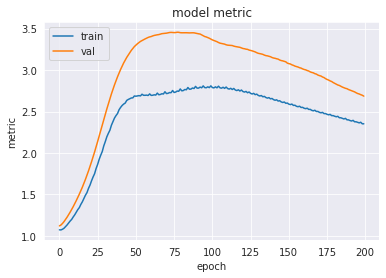

In [37]:
# summarize history for metric
path = './data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/metric_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.png'

adjustment_threshold_metric = 0#100
    
metric_df_adjusted = metric_df.copy(deep=True)
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True)
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model metric')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(path)
plt.show()


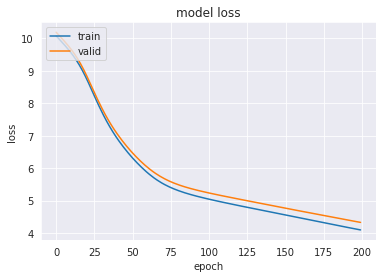

In [38]:
# summarize history for loss
path = './data/results/weights_' + str(data_size) + '_train_' + str(lambda_dataset_size) + '_variables_' + str(n) + '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_astep_' + str(a_step)  + '_amin_' + str(a_min) + '_amax_' + str(a_max) + '_xstep_' + str(x_step) + '_xmin_' + str(x_min) + '_xmax_' + str(x_max) + training_string + filename + '/loss_' + str(data_size) +  '_degree_' + str(d) + '_sparsity_' + str(sparsity) + '_amax_' + str(a_max) + '_xmax_' + str(x_max) + training_string + '_epoch_' + str(epochs).zfill(3)  + filename + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True)

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True)
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


## Mail Notification

In [53]:
#import sys
#sys.path.insert(0,'../_baselib/pymail')
#import mail_notifier

#mail_notifier.notification(sender='lahoffma.ines@gmail.com', 
#                           to='hoffmann@es.uni-mannheim.de', 
#                           subject='PyMail - 02_lambda_net Finished', 
#                           notification='The entire notebook was executed successfully!')

ModuleNotFoundError: No module named 'mail_notifier'

In [ ]:
%%email lahoffma.ines@gmail.com --to hoffmann@es.uni-mannheim.de --s '[PyMail] Lambda-Net Notebook Finished' --keep-password
print('Success')